# **StyleGAN-2 for feature extraction**
This notebook is based on that [GitHub](https://github.com/karray/stylegan2-pytorch/tree/master).

## **Install dependencies**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-36b430e3-5bd0-5eb1-c17e-607faa40ff24)


In [2]:
!ninja --version

/bin/bash: line 1: ninja: command not found


In [3]:
!git clone https://github.com/karray/stylegan2-pytorch/

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 416 (delta 5), reused 7 (delta 5), pack-reused 407
Receiving objects: 100% (416/416), 122.53 MiB | 25.97 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [ ]:
import os
!pip install gdown --upgrade

if os.path.isdir("/content/drive/MyDrive/style-gan-2"):
    %cd "/content/drive/MyDrive/style-gan-2/stylegan2-pytorch"
elif os.path.isdir("/content/drive/"):
    %cd "/content/drive/MyDrive/"
    !mkdir style-gan-2
    %cd style-gan-2
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    #!gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/style-gan-2/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    %cd pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

In [ ]:
!pip uninstall jax jaxlib -y
!pip install "jax[cuda11_cudnn805]==0.3.10" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip uninstall torch torchvision -y
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12 ftfy==6.1.1 ninja==1.10.2 opensimplex
!pip install wandb

## **Library imports**

### *Solve minor errors in scripts*

In [1]:
# to solve name conflict with Python modules
!mv /content/stylegan2-pytorch/distributed.py /content/stylegan2-pytorch/distributed_utils.py

mv: cannot stat '/content/stylegan2-pytorch/distributed.py': No such file or directory


In [2]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[7] = 'from distributed_utils import reduce_sum\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [3]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[359] = '        op = torch._C._jit_get_operation("aten::grid_sampler_2d_backward")[0]\n'
lines[360] = '        grad_input, grad_grid = op(grad_output, input, grid, 0, 0, False, [True, True])\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

### *Imports*


In [4]:
import sys
sys.path.append('/content/stylegan2-pytorch/')

In [5]:
import math
import random
import functools
import operator
import argparse
import os
from os.path import join as ospj
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.autograd import Function
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils
from torchvision.datasets import MNIST

from op import fused_leaky_relu, upfirdn2d, conv2d_gradfix
from model import Generator, Generator1, DiscriminatorMini, MappingNetwork, Encoder
from distributed_utils import get_rank, synchronize, reduce_loss_dict, reduce_sum, get_world_size
from op import conv2d_gradfix
from non_leaking import augment, AdaptiveAugment

import wandb

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


## **Training script**

In [6]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return [torch.randn(batch, latent_dim, device=device)]

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return make_noise(batch, latent_dim, 1, device)


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


def train(args, loader, generator, discriminator,mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
            sample_dir, working_dir):

    pbar = range(args.iter)

    if get_rank() == 0:
        pbar = tqdm(pbar, initial=args.start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}

    if args.distributed:
        g_module = generator.module
        d_module = discriminator.module
        f_module = mapping.module
        e_module = encoder.module

    else:
        g_module = generator
        d_module = discriminator
        f_module = mapping
        e_module = encoder

    accum = 0.5 ** (32 / (10 * 1000))
    ada_aug_p = args.augment_p if args.augment_p > 0 else 0.0
    r_t_stat = 0

    if args.augment and args.augment_p == 0:
        ada_augment = AdaptiveAugment(args.ada_target, args.ada_length, 8, device)

    for idx in pbar:
        i = idx + args.start_iter

        if i > args.iter:
            print("Done!")
            break

        real_img = next(loader)
        real_img = real_img[0].to(device)

        requires_grad(generator, False)
        requires_grad(mapping, False)
        requires_grad(discriminator, True)
        requires_grad(encoder, True)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            real_img_aug, _ = augment(real_img, ada_aug_p)
            fake_img, _ = augment(fake_img, ada_aug_p)

        else:
            real_img_aug = real_img

        fake_pred = discriminator(encoder(fake_img))
        real_pred = discriminator(encoder(real_img_aug))
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        encoder.zero_grad()
        d_loss.backward()
        d_optim.step()
        e_optim.step()

        if args.augment and args.augment_p == 0:
            ada_aug_p = ada_augment.tune(real_pred)
            r_t_stat = ada_augment.r_t_stat

        d_regularize = i % args.d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True

            if args.augment:
                real_img_aug, _ = augment(real_img, ada_aug_p)

            else:
                real_img_aug = real_img

            real_pred = discriminator(encoder(real_img_aug))
            r1_loss = d_r1_loss(real_pred, real_img)

            discriminator.zero_grad()
            encoder.zero_grad()
            (args.r1 / 2 * r1_loss * args.d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()
            e_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, False)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            fake_img, _ = augment(fake_img, ada_aug_p)

        fake_pred = discriminator(encoder(fake_img))
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        g_loss.backward()
        g_optim.step()
        f_optim.step()

        g_regularize = i % args.g_reg_every == 0

        if g_regularize:
            path_batch_size = max(1, args.batch // args.path_batch_shrink)
            noise = mixing_noise(path_batch_size, args.latent, args.mixing, device)
            fake_img, latents = generator([mapping(z) for z in noise], return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            mapping.zero_grad()
            weighted_path_loss = args.path_regularize * args.g_reg_every * path_loss

            if args.path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()
            f_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, True)

        w_z = mapping(torch.randn(args.batch, args.latent, device=device))
        fake_img, _ = generator([w_z])
        consitency_loss = (w_z - encoder(fake_img)).pow(2).mean()

        loss_dict["consitency_loss"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        encoder.zero_grad()
        consitency_loss.backward()
        g_optim.step()
        f_optim.step()
        e_optim.step()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)

        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()
        w_consitency_loss = loss_reduced["consitency_loss"].mean().item()

        if get_rank() == 0:

            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}; "
                    f"augment: {ada_aug_p:.4f}"
                )
            )

            if (i+1) % 100 == 0:

                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "f": f_module.state_dict(),
                        "e": e_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "f_optim": f_optim.state_dict(),
                        "e_optim": e_optim.state_dict(),
                        "args": args,
                        "ada_aug_p": ada_aug_p,
                    },
                    ospj(working_dir, f"checkpoint_last.pt"),
                )

                with torch.no_grad():
                    g_ema.eval()

                    debug_img = [debug_images]

                    # reconstruct real images
                    w = encoder(debug_images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # generate from noise
                    w = mapping(debug_z)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # reconstruct from noise
                    w = encoder(images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    debug_img = torch.cat(debug_img, dim=0)

                    debug_img = debug_img.view(4, 8, 3, 32, 32)
                    debug_img = debug_img.permute(0, 3, 1, 4, 2)
                    debug_img = debug_img.reshape(4 * 32, 8 * 32, 3)

                    debug_img = debug_img.cpu().numpy()

                    plt.figure(figsize=(8, 8))
                    plt.imshow(debug_img)
                    plt.axis('off')
                    plt.show()

## **Define parameters**

In [7]:
sys.argv = [
    'script_name', '--path', 'data', '--arch', 'stylegan2', '--iter', '10000',
    '--batch', '32', '--n_sample', '64', '--r1', '10', '--path_regularize', '2',
    '--path_batch_shrink', '2', '--d_reg_every', '16', '--g_reg_every', '4',
    '--mixing', '0.9', '--ckpt', 'None', '--lr', '0.002', '--channel_multiplier', '2',
    '--local_rank', '0', '--augment', '--augment_p', '0', '--ada_target', '0.6',
    '--ada_length', '500000', '--ada_every', '256', '--gpu', '0', '--name', 'experiment',
    '--run_name', 'run1'
]

## **Training loop**

d: 1.3705; g: 2.0271; r1: 0.0249; path: 0.0533; mean path: 0.1134; augment: 0.0031:   1%|          | 99/10000 [03:12<5:18:30,  1.93s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


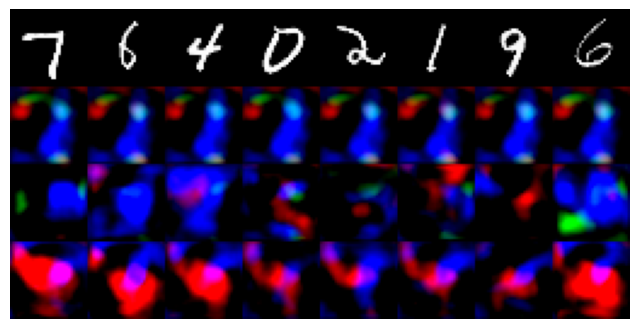

d: 0.0425; g: 4.7142; r1: 0.0104; path: 0.0090; mean path: 0.1501; augment: 0.0087:   2%|▏         | 199/10000 [06:32<5:20:17,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


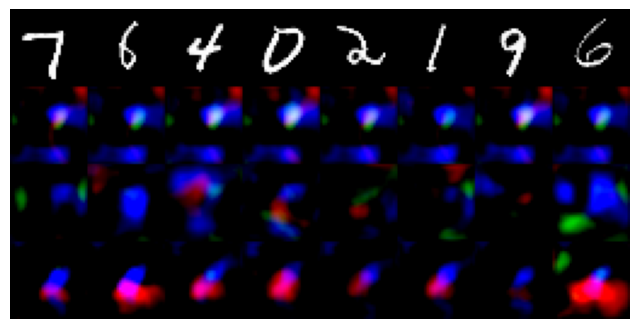

d: 0.1071; g: 3.2360; r1: 0.0330; path: 0.0142; mean path: 0.1709; augment: 0.0128:   3%|▎         | 299/10000 [09:48<5:15:34,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


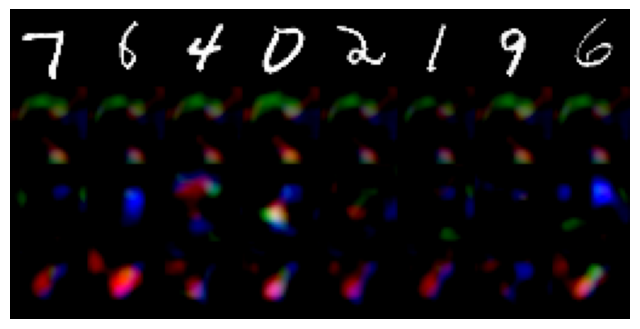

d: 0.2634; g: 3.6641; r1: 0.0105; path: 0.0073; mean path: 0.1932; augment: 0.0164:   4%|▍         | 399/10000 [13:05<5:11:53,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


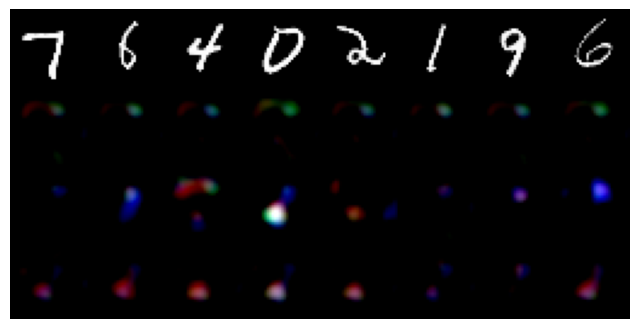

d: 1.0304; g: 2.0867; r1: 0.0067; path: 0.0130; mean path: 0.2077; augment: 0.0184:   5%|▍         | 499/10000 [16:21<5:08:47,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.1767; g: 0.5536; r1: 0.0734; path: 0.0009; mean path: 0.2171; augment: 0.0210:   6%|▌         | 599/10000 [19:37<5:05:17,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


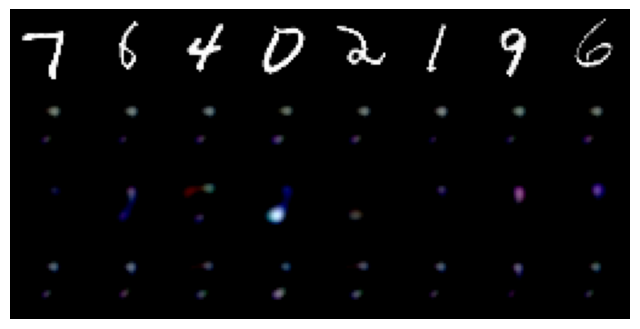

d: 1.2789; g: 1.6496; r1: 0.0175; path: 0.0011; mean path: 0.2188; augment: 0.0210:   7%|▋         | 699/10000 [22:52<5:01:42,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


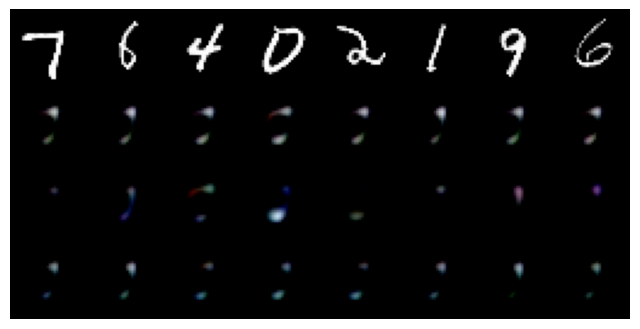

d: 1.2076; g: 0.8351; r1: 0.1898; path: 0.0017; mean path: 0.2220; augment: 0.0225:   8%|▊         | 799/10000 [26:11<5:00:08,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


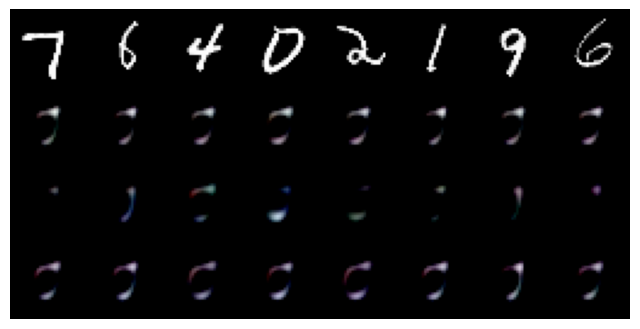

d: 1.1833; g: 2.0318; r1: 0.0076; path: 0.0025; mean path: 0.2266; augment: 0.0225:   9%|▉         | 899/10000 [29:31<4:58:08,  1.97s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


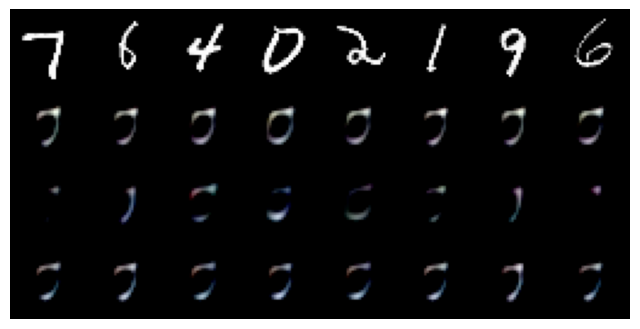

d: 1.0323; g: 0.3033; r1: 0.0124; path: 0.0024; mean path: 0.2280; augment: 0.0241:  10%|▉         | 999/10000 [32:46<4:52:54,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


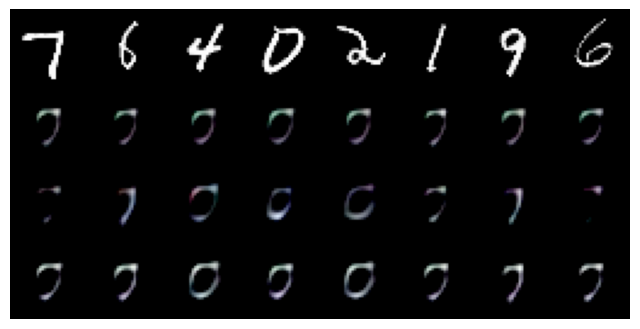

d: 1.3082; g: 0.7682; r1: 0.0695; path: 0.0043; mean path: 0.2289; augment: 0.0230:  11%|█         | 1099/10000 [36:01<4:48:47,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


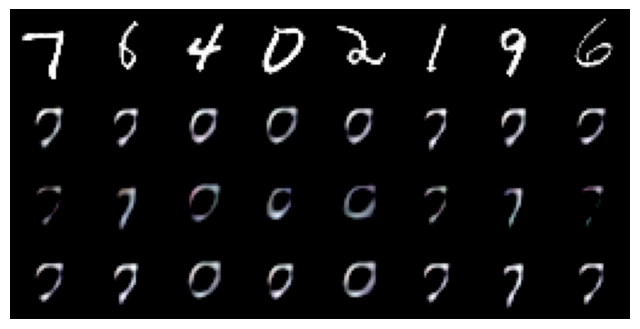

d: 1.3027; g: 0.9943; r1: 0.0583; path: 0.0024; mean path: 0.2300; augment: 0.0174:  12%|█▏        | 1199/10000 [39:17<4:45:40,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2813; g: 0.6779; r1: 0.0051; path: 0.0038; mean path: 0.2310; augment: 0.0143:  13%|█▎        | 1299/10000 [42:33<4:42:41,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


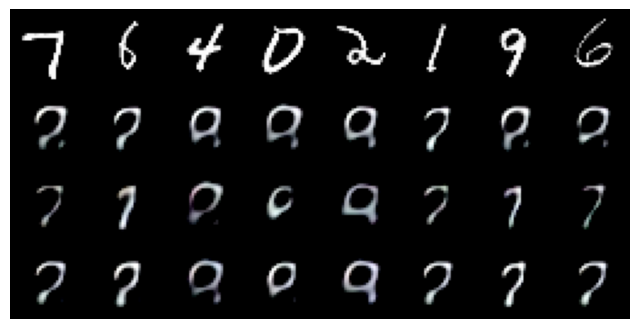

d: 1.2059; g: 1.1346; r1: 0.0089; path: 0.0012; mean path: 0.2312; augment: 0.0077:  14%|█▍        | 1399/10000 [45:49<4:39:26,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


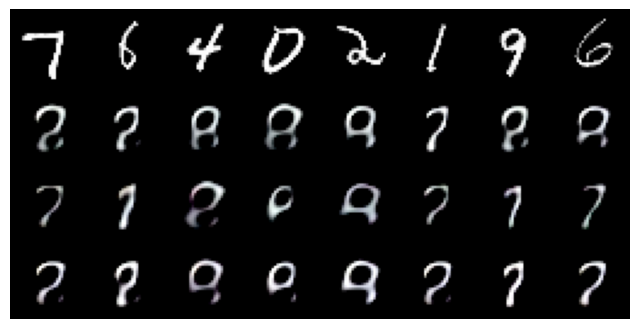

d: 1.1137; g: 1.2183; r1: 0.0215; path: 0.0057; mean path: 0.2322; augment: 0.0046:  15%|█▍        | 1499/10000 [49:10<4:38:55,  1.97s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


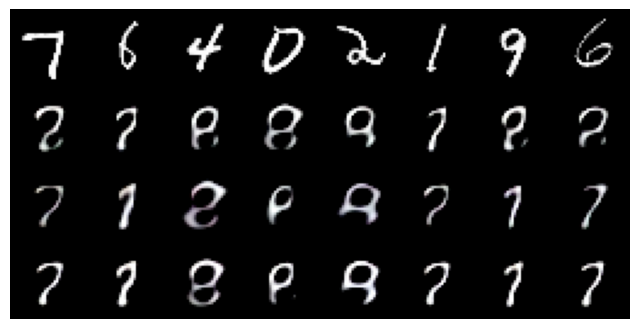

d: 1.2483; g: 0.8299; r1: 0.0384; path: 0.0031; mean path: 0.2327; augment: 0.0000:  16%|█▌        | 1599/10000 [52:26<4:33:23,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


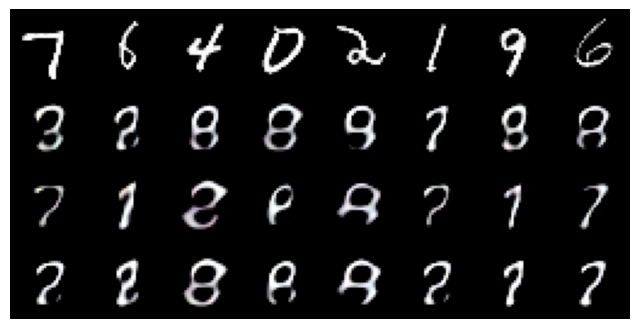

d: 1.2634; g: 0.8098; r1: 0.0036; path: 0.0024; mean path: 0.2322; augment: 0.0000:  17%|█▋        | 1699/10000 [55:41<4:29:34,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


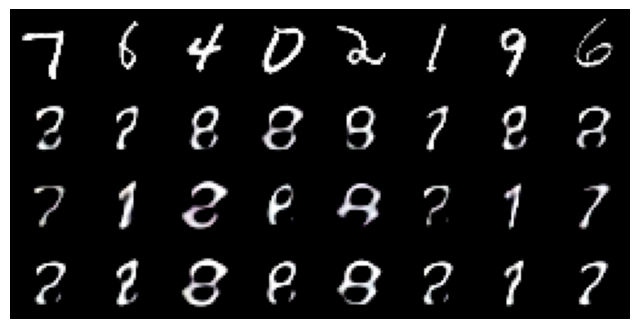

d: 1.2366; g: 0.7325; r1: 0.0009; path: 0.0048; mean path: 0.2362; augment: 0.0000:  18%|█▊        | 1799/10000 [58:57<4:25:52,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


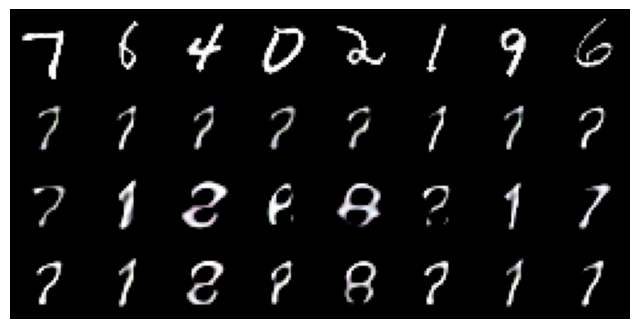

d: 1.2736; g: 0.7854; r1: 0.0250; path: 0.0033; mean path: 0.2404; augment: 0.0000:  19%|█▉        | 1899/10000 [1:02:12<4:22:34,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


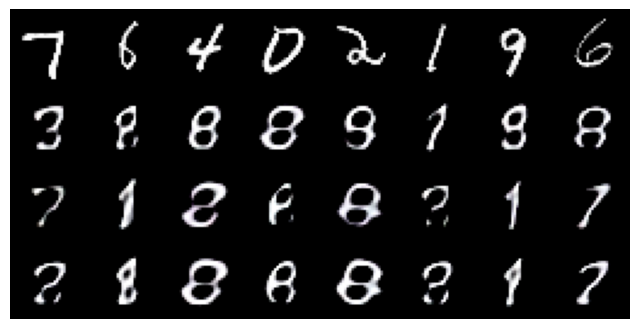

d: 1.3141; g: 1.1201; r1: 0.0069; path: 0.0028; mean path: 0.2439; augment: 0.0000:  20%|█▉        | 1999/10000 [1:05:29<4:19:58,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


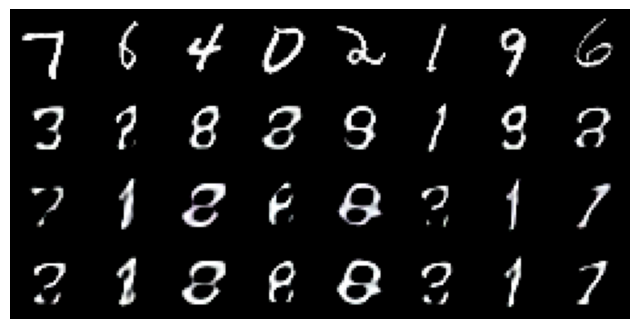

d: 1.1032; g: 1.3122; r1: 0.0068; path: 0.0032; mean path: 0.2475; augment: 0.0000:  21%|██        | 2099/10000 [1:08:46<4:16:51,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


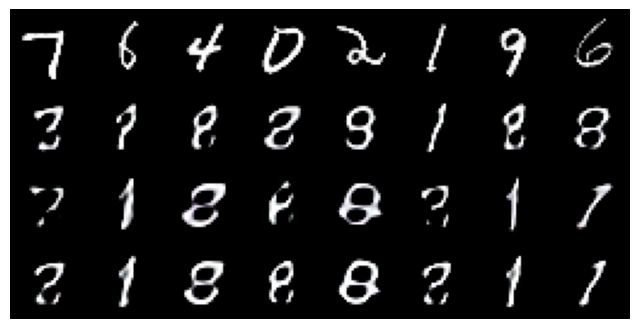

d: 1.2774; g: 0.8521; r1: 0.0062; path: 0.0034; mean path: 0.2494; augment: 0.0010:  22%|██▏       | 2199/10000 [1:12:03<4:14:01,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


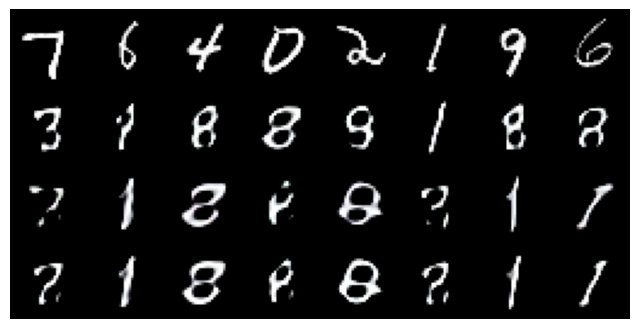

d: 1.3003; g: 0.8264; r1: 0.0851; path: 0.0081; mean path: 0.2515; augment: 0.0005:  23%|██▎       | 2299/10000 [1:15:18<4:09:57,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


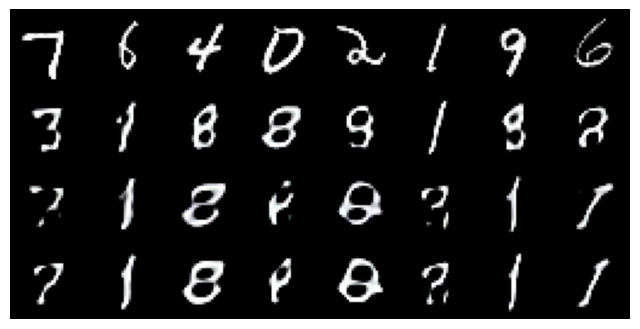

d: 1.2564; g: 0.8117; r1: 0.0150; path: 0.0090; mean path: 0.2550; augment: 0.0026:  24%|██▍       | 2399/10000 [1:18:34<4:06:15,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


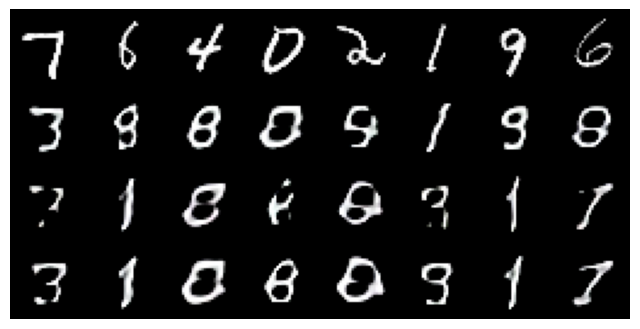

d: 1.1618; g: 1.1278; r1: 0.0026; path: 0.0030; mean path: 0.2581; augment: 0.0005:  25%|██▍       | 2499/10000 [1:21:52<4:04:15,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


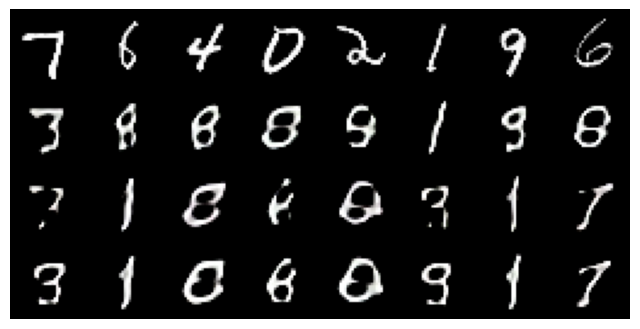

d: 1.0565; g: 1.2607; r1: 0.0042; path: 0.0054; mean path: 0.2600; augment: 0.0000:  26%|██▌       | 2599/10000 [1:25:07<4:00:28,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


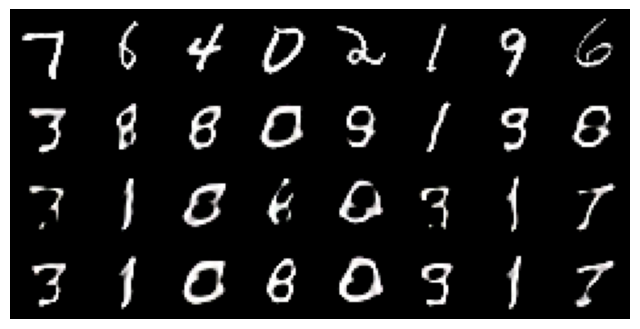

d: 1.3196; g: 0.9821; r1: 0.0018; path: 0.0077; mean path: 0.2646; augment: 0.0000:  27%|██▋       | 2699/10000 [1:28:23<3:56:33,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


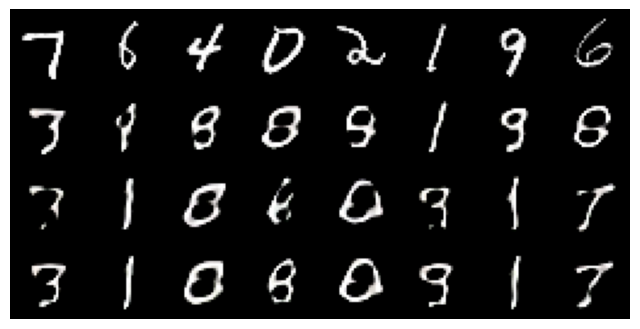

d: 1.2734; g: 1.2377; r1: 0.0014; path: 0.0084; mean path: 0.2670; augment: 0.0000:  28%|██▊       | 2799/10000 [1:31:38<3:53:21,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


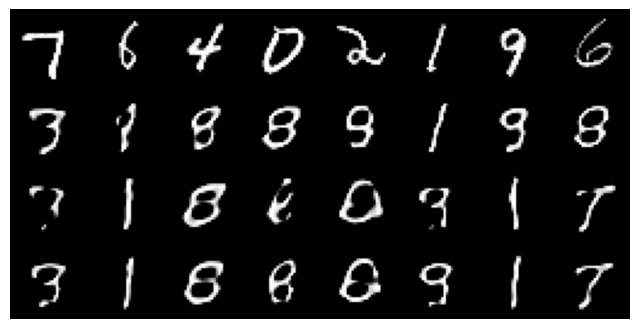

d: 1.0959; g: 1.2636; r1: 0.0071; path: 0.0049; mean path: 0.2577; augment: 0.0005:  29%|██▉       | 2899/10000 [1:34:56<3:51:12,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


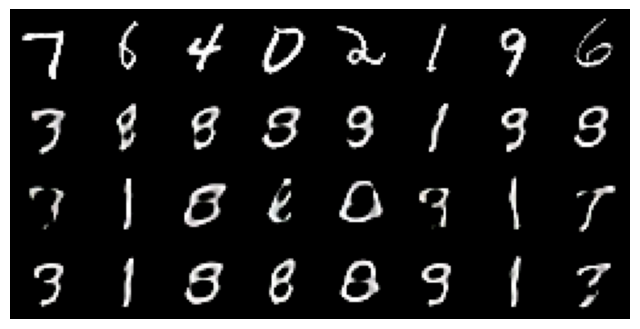

d: 1.3034; g: 0.7882; r1: 0.0113; path: 0.0066; mean path: 0.2629; augment: 0.0000:  30%|██▉       | 2999/10000 [1:38:11<3:47:16,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


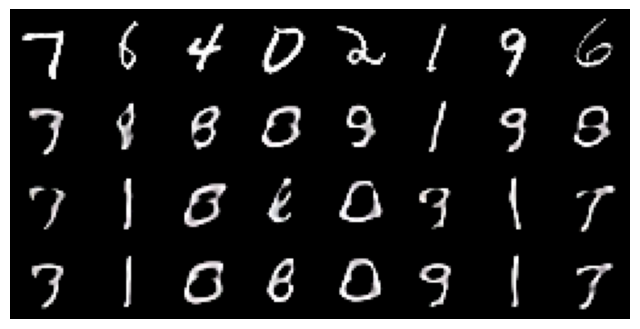

d: 1.1723; g: 1.0634; r1: 0.0221; path: 0.0092; mean path: 0.2680; augment: 0.0000:  31%|███       | 3099/10000 [1:41:27<3:43:32,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


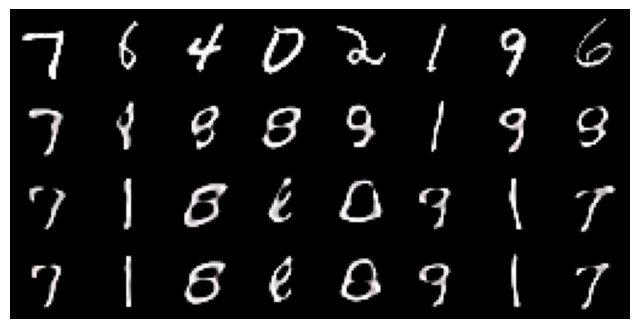

d: 1.2932; g: 0.7313; r1: 0.0266; path: 0.0049; mean path: 0.2764; augment: 0.0000:  32%|███▏      | 3199/10000 [1:44:44<3:41:05,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


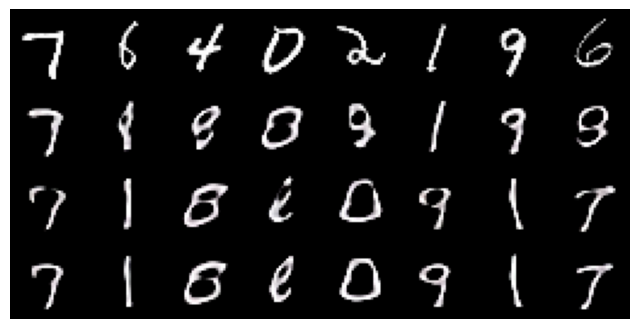

d: 1.2981; g: 0.8075; r1: 0.0076; path: 0.0055; mean path: 0.2840; augment: 0.0000:  33%|███▎      | 3299/10000 [1:48:00<3:37:52,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


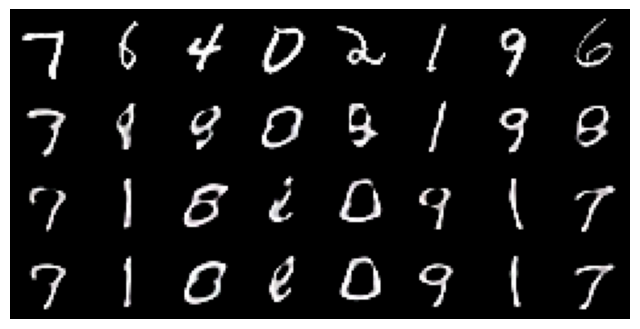

d: 1.2828; g: 1.4161; r1: 0.0038; path: 0.0059; mean path: 0.2890; augment: 0.0000:  34%|███▍      | 3399/10000 [1:51:16<3:34:04,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2403; g: 0.8159; r1: 0.0080; path: 0.0106; mean path: 0.2893; augment: 0.0020:  35%|███▍      | 3499/10000 [1:54:31<3:30:49,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


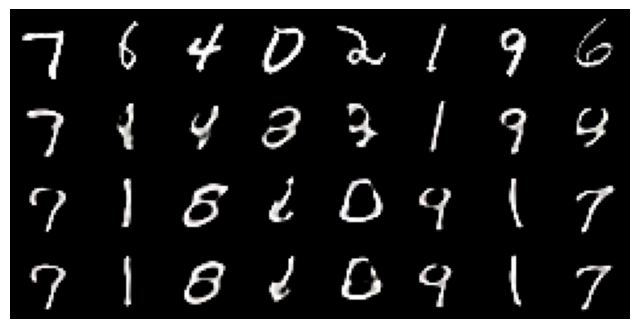

d: 1.3081; g: 0.6228; r1: 0.0045; path: 0.0096; mean path: 0.2921; augment: 0.0015:  36%|███▌      | 3599/10000 [1:57:47<3:27:23,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


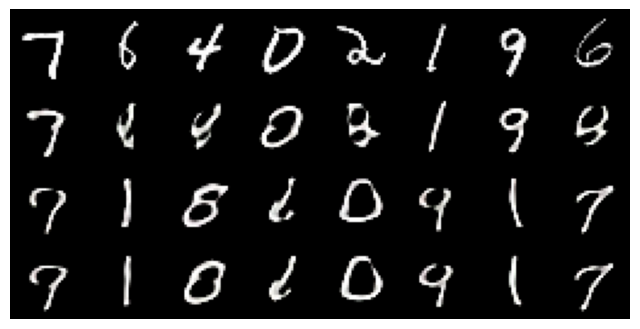

d: 1.3021; g: 0.8127; r1: 0.0107; path: 0.0052; mean path: 0.2976; augment: 0.0005:  37%|███▋      | 3699/10000 [2:01:03<3:24:44,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


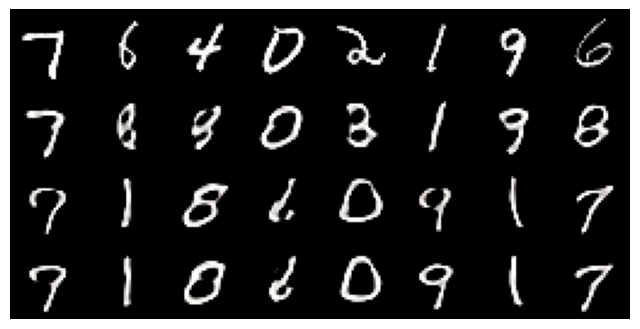

d: 1.2769; g: 0.7842; r1: 0.0139; path: 0.0069; mean path: 0.3005; augment: 0.0000:  38%|███▊      | 3799/10000 [2:04:19<3:21:12,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


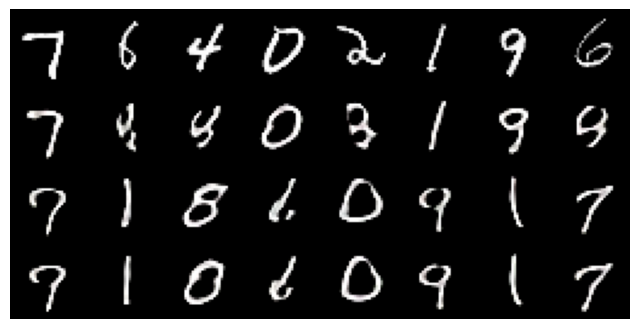

d: 1.3052; g: 0.7794; r1: 0.0093; path: 0.0086; mean path: 0.3054; augment: 0.0000:  39%|███▉      | 3899/10000 [2:07:35<3:18:01,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3408; g: 0.7644; r1: 0.2975; path: 0.0081; mean path: 0.3051; augment: 0.0000:  40%|███▉      | 3999/10000 [2:10:56<3:16:33,  1.97s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3265; g: 0.7293; r1: 0.0070; path: 0.0076; mean path: 0.3071; augment: 0.0000:  41%|████      | 4099/10000 [2:14:12<3:12:31,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


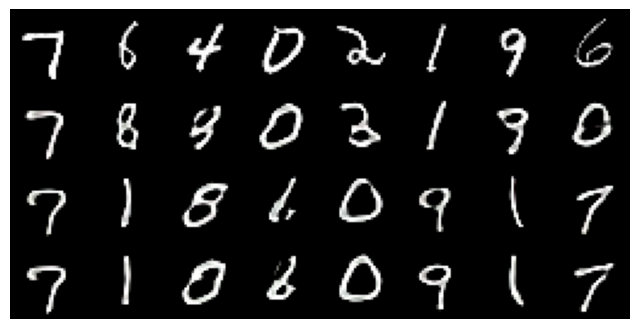

d: 1.4653; g: 1.0066; r1: 0.0025; path: 0.0090; mean path: 0.3099; augment: 0.0000:  42%|████▏     | 4199/10000 [2:17:28<3:08:38,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


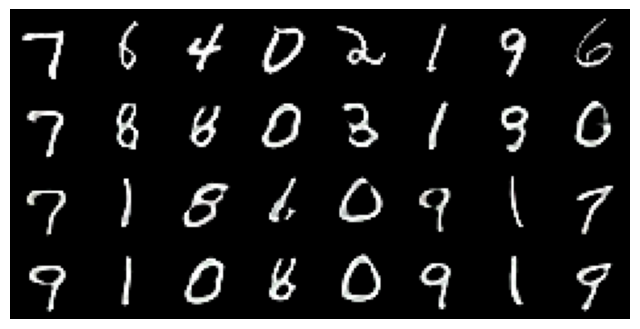

d: 1.3233; g: 0.7157; r1: 0.0034; path: 0.0142; mean path: 0.3122; augment: 0.0000:  43%|████▎     | 4299/10000 [2:20:45<3:05:17,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


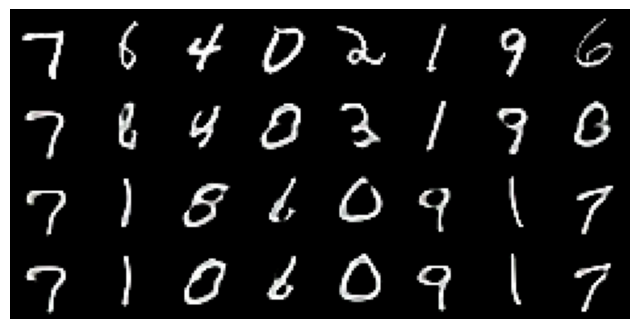

d: 1.3036; g: 0.8223; r1: 0.0171; path: 0.0142; mean path: 0.3156; augment: 0.0000:  44%|████▍     | 4399/10000 [2:24:02<3:02:22,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3581; g: 0.7013; r1: 0.0004; path: 0.0058; mean path: 0.3128; augment: 0.0000:  45%|████▍     | 4499/10000 [2:27:18<2:58:49,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


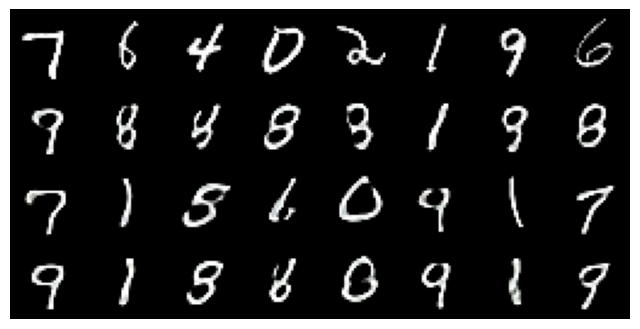

d: 1.3011; g: 0.7466; r1: 0.0043; path: 0.0040; mean path: 0.3160; augment: 0.0000:  46%|████▌     | 4599/10000 [2:30:34<2:55:22,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3247; g: 1.0736; r1: 0.0051; path: 0.0155; mean path: 0.3191; augment: 0.0000:  47%|████▋     | 4699/10000 [2:33:49<2:52:00,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


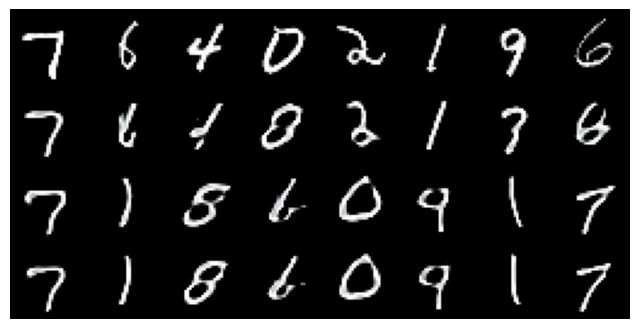

d: 1.1416; g: 1.1404; r1: 0.0010; path: 0.0127; mean path: 0.3232; augment: 0.0000:  48%|████▊     | 4799/10000 [2:37:05<2:48:31,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3035; g: 0.7894; r1: 0.0175; path: 0.0087; mean path: 0.3261; augment: 0.0000:  49%|████▉     | 4899/10000 [2:40:21<2:45:47,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


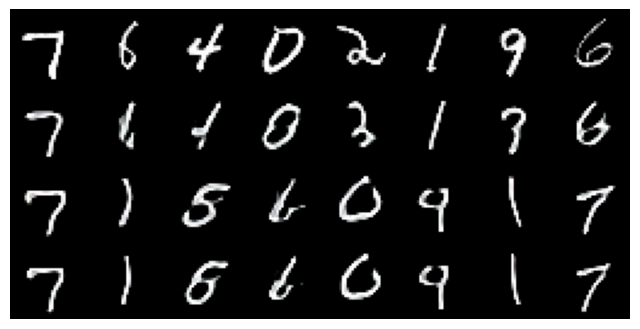

d: 1.3376; g: 0.7302; r1: 0.0056; path: 0.0120; mean path: 0.3303; augment: 0.0000:  50%|████▉     | 4999/10000 [2:43:37<2:42:11,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


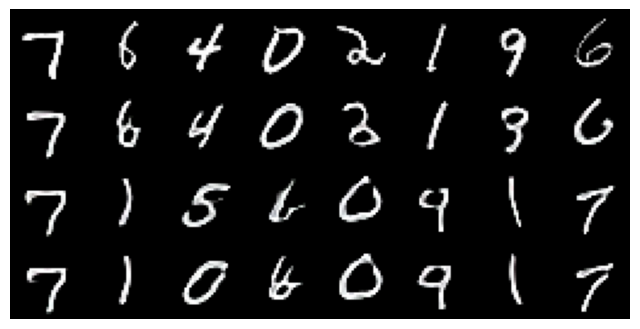

d: 1.3766; g: 1.6449; r1: 0.0056; path: 0.0145; mean path: 0.3307; augment: 0.0000:  51%|█████     | 5099/10000 [2:46:52<2:38:55,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


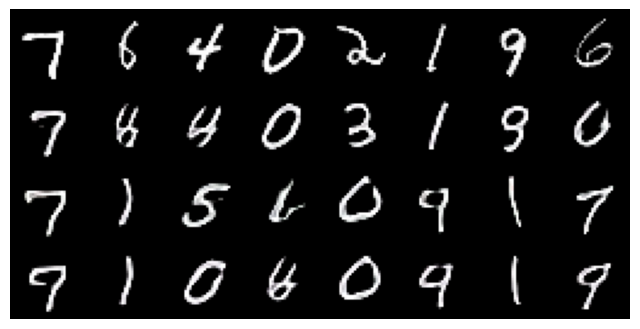

d: 1.2800; g: 0.8729; r1: 0.0046; path: 0.0098; mean path: 0.3339; augment: 0.0000:  52%|█████▏    | 5199/10000 [2:50:09<2:35:50,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


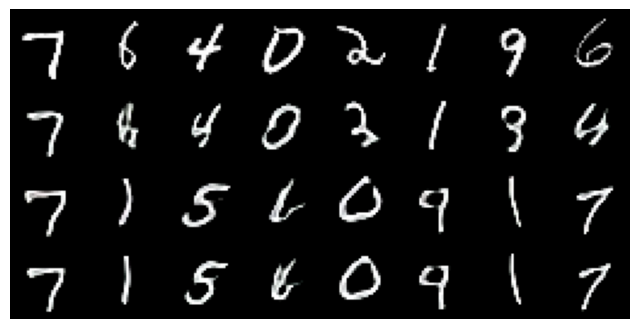

d: 1.2787; g: 0.8134; r1: 0.0097; path: 0.0079; mean path: 0.3374; augment: 0.0000:  53%|█████▎    | 5299/10000 [2:53:25<2:32:42,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


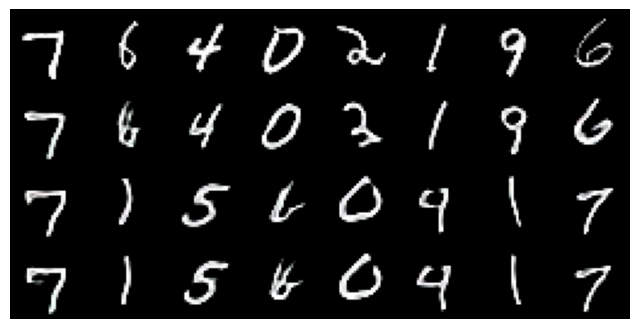

d: 1.2940; g: 0.8217; r1: 0.0130; path: 0.0179; mean path: 0.3410; augment: 0.0000:  54%|█████▍    | 5399/10000 [2:56:40<2:29:21,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


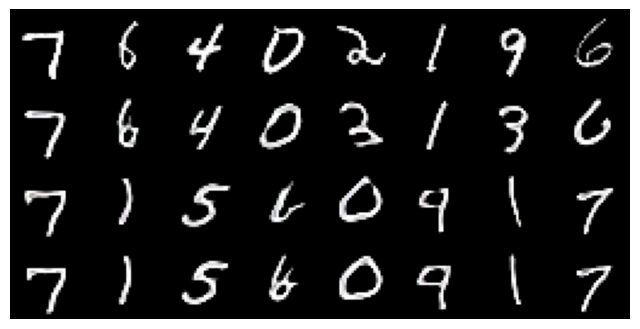

d: 1.3450; g: 0.7840; r1: 0.0043; path: 0.0066; mean path: 0.3464; augment: 0.0000:  55%|█████▍    | 5499/10000 [2:59:56<2:25:57,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


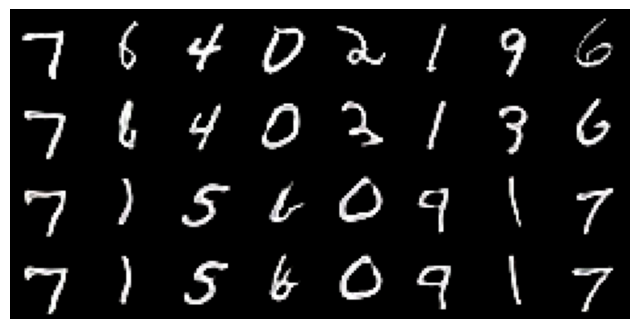

d: 1.2623; g: 0.9071; r1: 0.0064; path: 0.0100; mean path: 0.3492; augment: 0.0000:  56%|█████▌    | 5599/10000 [3:03:12<2:22:36,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


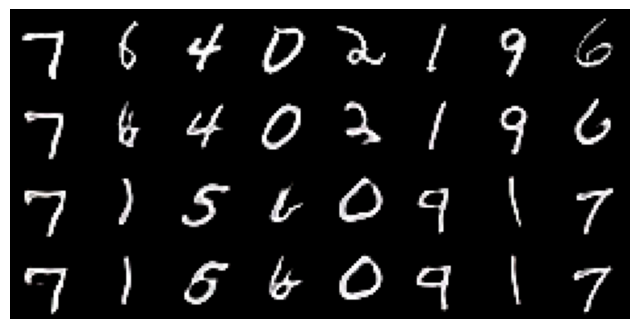

d: 1.2937; g: 0.7205; r1: 0.0029; path: 0.0058; mean path: 0.3508; augment: 0.0000:  57%|█████▋    | 5699/10000 [3:06:31<2:20:31,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


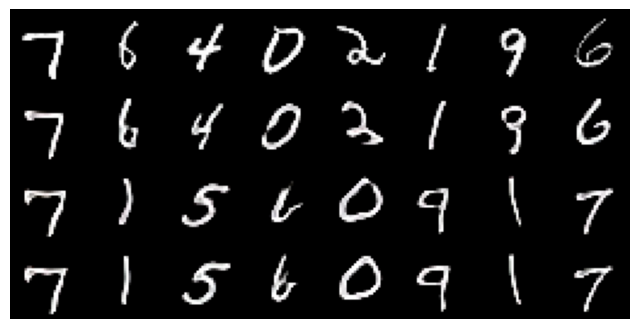

d: 1.3316; g: 0.6879; r1: 0.0030; path: 0.0105; mean path: 0.3527; augment: 0.0000:  58%|█████▊    | 5799/10000 [3:09:49<2:17:08,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


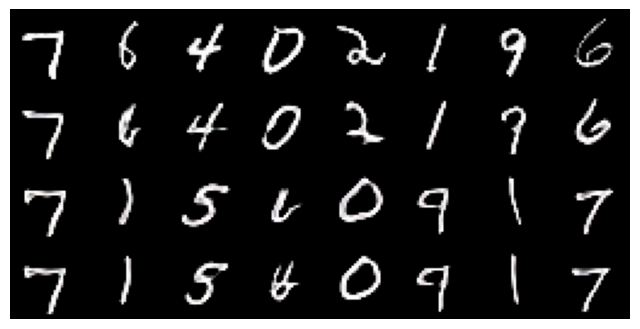

d: 1.3378; g: 0.7286; r1: 0.0210; path: 0.0073; mean path: 0.3547; augment: 0.0000:  59%|█████▉    | 5899/10000 [3:13:04<2:13:10,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


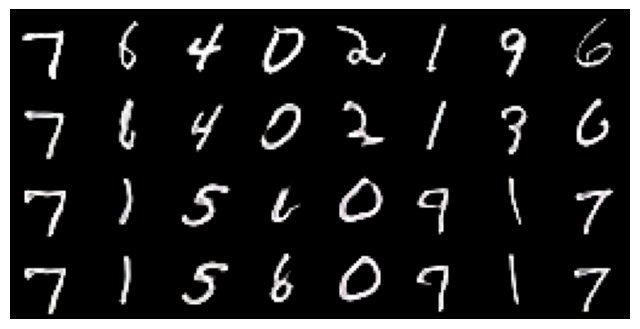

d: 1.2108; g: 1.0689; r1: 0.0177; path: 0.0206; mean path: 0.3566; augment: 0.0000:  60%|█████▉    | 5999/10000 [3:16:19<2:09:41,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


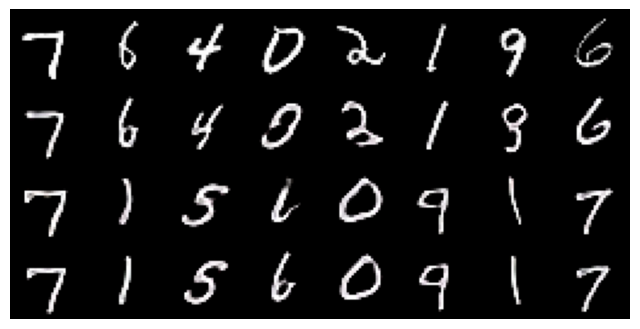

d: 1.2806; g: 0.7245; r1: 0.0177; path: 0.0117; mean path: 0.3588; augment: 0.0000:  61%|██████    | 6099/10000 [3:19:35<2:06:35,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


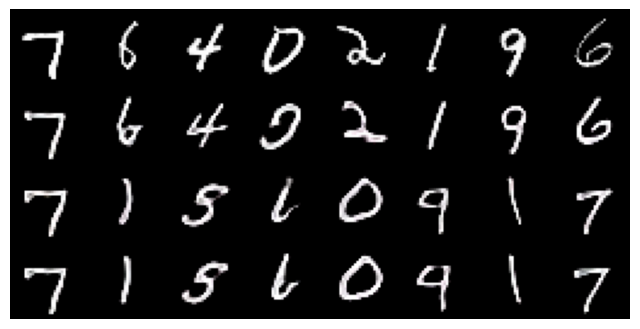

d: 1.2920; g: 0.7937; r1: 0.0308; path: 0.0069; mean path: 0.3632; augment: 0.0000:  62%|██████▏   | 6199/10000 [3:22:56<2:04:30,  1.97s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


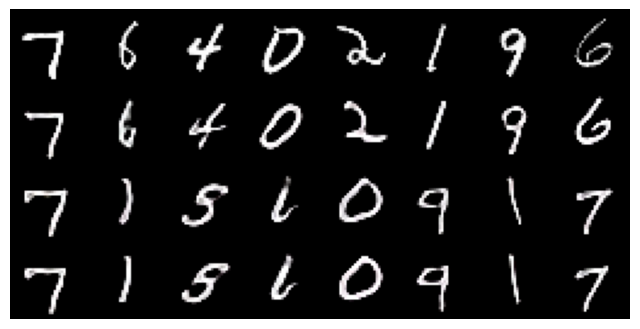

d: 1.2977; g: 0.8141; r1: 0.0040; path: 0.0158; mean path: 0.3647; augment: 0.0000:  63%|██████▎   | 6299/10000 [3:26:12<2:00:28,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


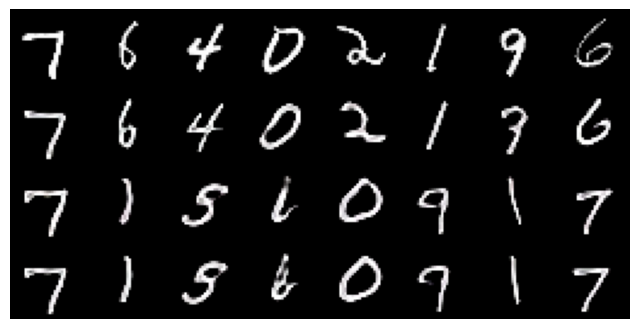

d: 1.2354; g: 0.7473; r1: 0.0051; path: 0.0183; mean path: 0.3679; augment: 0.0000:  64%|██████▍   | 6399/10000 [3:29:28<1:56:59,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


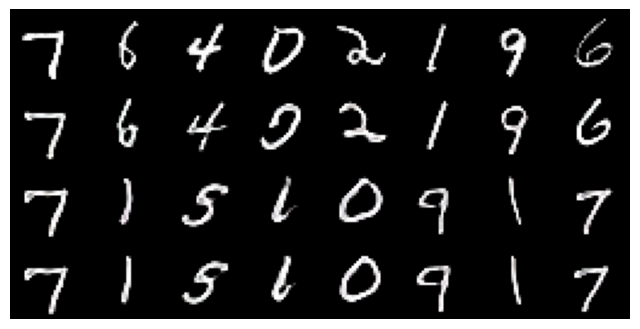

d: 1.2325; g: 1.0507; r1: 0.0026; path: 0.0112; mean path: 0.3691; augment: 0.0000:  65%|██████▍   | 6499/10000 [3:32:44<1:53:41,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


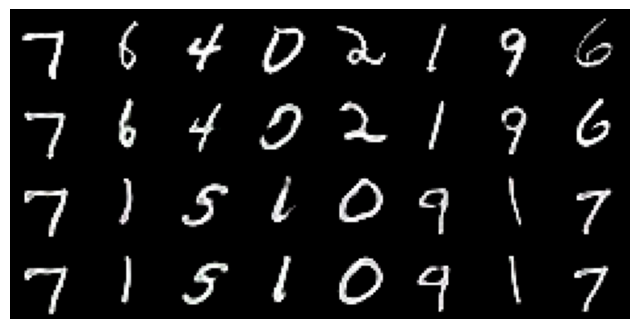

d: 1.3126; g: 0.7337; r1: 0.0286; path: 0.0107; mean path: 0.3720; augment: 0.0000:  66%|██████▌   | 6599/10000 [3:35:59<1:50:16,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2844; g: 0.8624; r1: 0.0080; path: 0.0108; mean path: 0.3748; augment: 0.0000:  67%|██████▋   | 6699/10000 [3:39:16<1:47:20,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2652; g: 0.8935; r1: 0.0122; path: 0.0243; mean path: 0.3766; augment: 0.0000:  68%|██████▊   | 6799/10000 [3:42:32<1:43:45,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


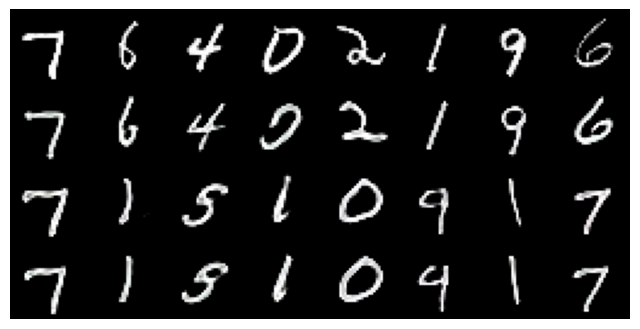

d: 1.3267; g: 0.7859; r1: 0.0119; path: 0.0218; mean path: 0.3784; augment: 0.0000:  69%|██████▉   | 6899/10000 [3:45:48<1:40:41,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


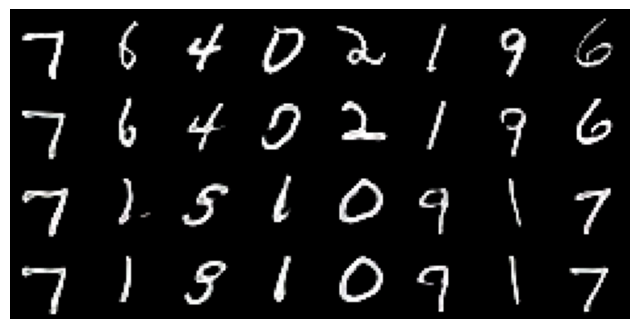

d: 1.3109; g: 0.8742; r1: 0.0153; path: 0.0147; mean path: 0.3814; augment: 0.0005:  70%|██████▉   | 6999/10000 [3:49:03<1:37:21,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


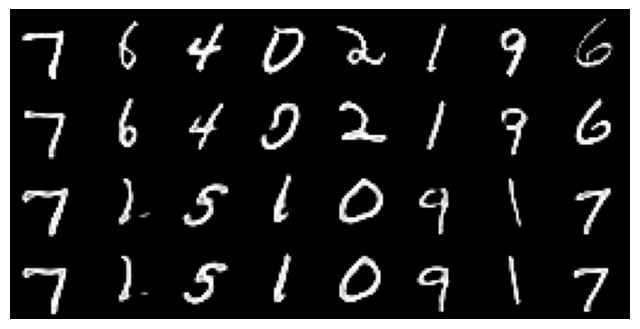

d: 1.2555; g: 0.7285; r1: 0.0076; path: 0.0101; mean path: 0.3809; augment: 0.0000:  71%|███████   | 7099/10000 [3:52:22<1:34:45,  1.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2531; g: 0.7980; r1: 0.0029; path: 0.0123; mean path: 0.3816; augment: 0.0000:  72%|███████▏  | 7199/10000 [3:55:38<1:31:00,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


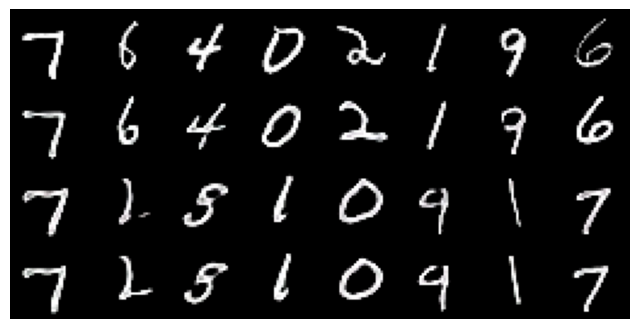

d: 1.3112; g: 0.9261; r1: 0.0062; path: 0.0103; mean path: 0.3839; augment: 0.0000:  73%|███████▎  | 7299/10000 [3:58:54<1:27:50,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


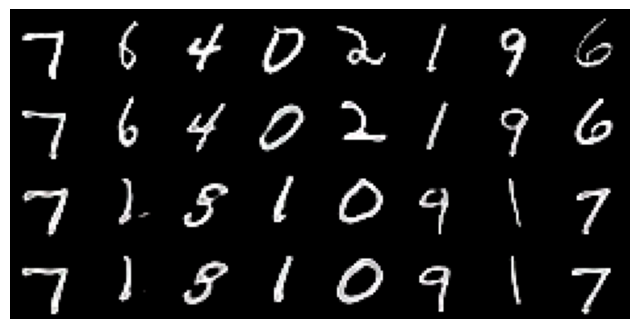

d: 1.2655; g: 0.9020; r1: 0.0067; path: 0.0204; mean path: 0.3855; augment: 0.0000:  74%|███████▍  | 7399/10000 [4:02:10<1:24:25,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.3027; g: 0.8420; r1: 0.0044; path: 0.0072; mean path: 0.3861; augment: 0.0000:  75%|███████▍  | 7499/10000 [4:05:26<1:21:14,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


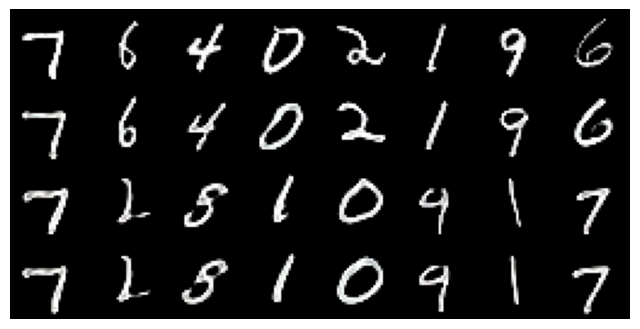

d: 1.3156; g: 0.7498; r1: 0.0183; path: 0.0134; mean path: 0.3870; augment: 0.0000:  76%|███████▌  | 7599/10000 [4:08:41<1:17:49,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


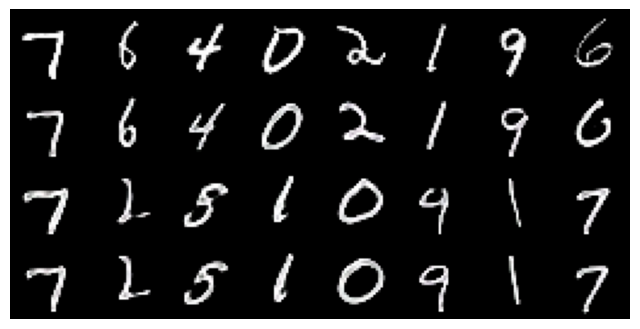

d: 1.3849; g: 0.7796; r1: 0.0026; path: 0.0064; mean path: 0.3879; augment: 0.0000:  77%|███████▋  | 7699/10000 [4:11:57<1:14:43,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


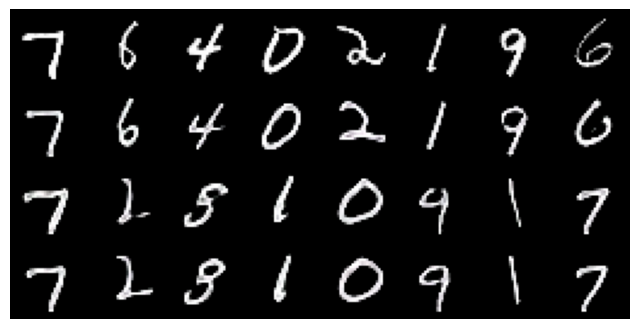

d: 1.2944; g: 0.7880; r1: 0.0117; path: 0.0183; mean path: 0.3878; augment: 0.0000:  78%|███████▊  | 7799/10000 [4:15:14<1:11:29,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


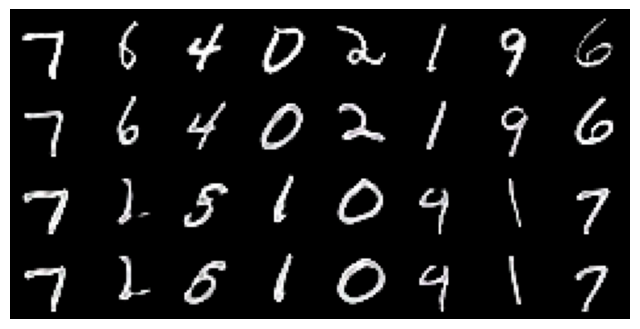

d: 1.2837; g: 0.6793; r1: 0.0484; path: 0.0096; mean path: 0.3858; augment: 0.0000:  79%|███████▉  | 7899/10000 [4:18:34<1:08:51,  1.97s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


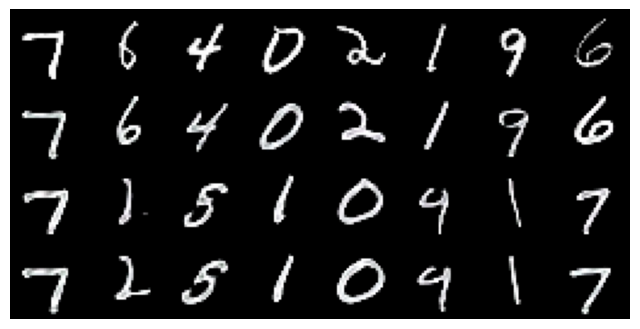

d: 1.3545; g: 0.8117; r1: 0.0102; path: 0.0190; mean path: 0.3877; augment: 0.0000:  80%|███████▉  | 7999/10000 [4:21:50<1:05:07,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


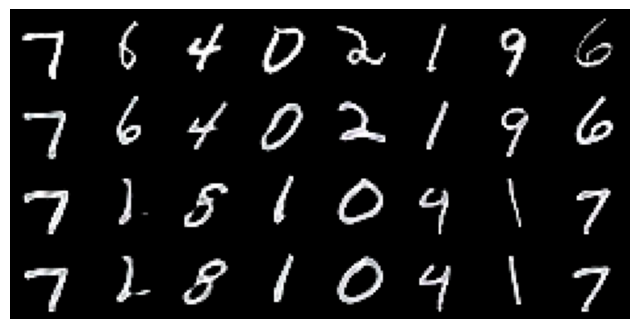

d: 1.2940; g: 0.7791; r1: 0.0056; path: 0.0110; mean path: 0.3879; augment: 0.0000:  81%|████████  | 8099/10000 [4:25:06<1:01:49,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2640; g: 1.0311; r1: 0.0045; path: 0.0048; mean path: 0.3888; augment: 0.0000:  82%|████████▏ | 8199/10000 [4:28:23<58:33,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


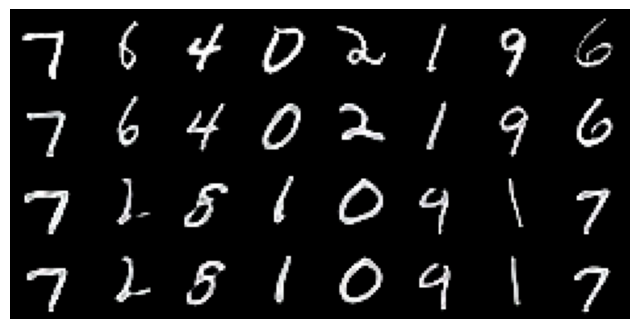

d: 1.1971; g: 1.4197; r1: 0.0062; path: 0.0109; mean path: 0.3904; augment: 0.0000:  83%|████████▎ | 8299/10000 [4:31:38<55:12,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


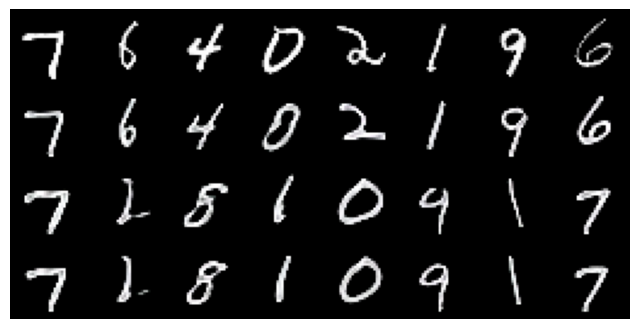

d: 1.2529; g: 0.6174; r1: 0.0049; path: 0.0047; mean path: 0.3913; augment: 0.0000:  84%|████████▍ | 8399/10000 [4:34:56<52:08,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


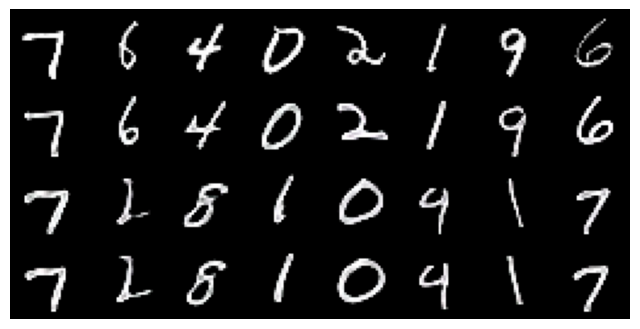

d: 1.2946; g: 0.7819; r1: 0.0228; path: 0.0115; mean path: 0.3920; augment: 0.0000:  85%|████████▍ | 8499/10000 [4:38:12<48:48,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


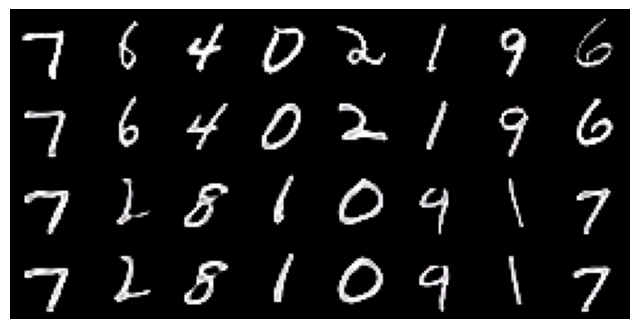

d: 1.3431; g: 0.7800; r1: 0.0056; path: 0.0100; mean path: 0.3917; augment: 0.0000:  86%|████████▌ | 8599/10000 [4:41:28<45:30,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


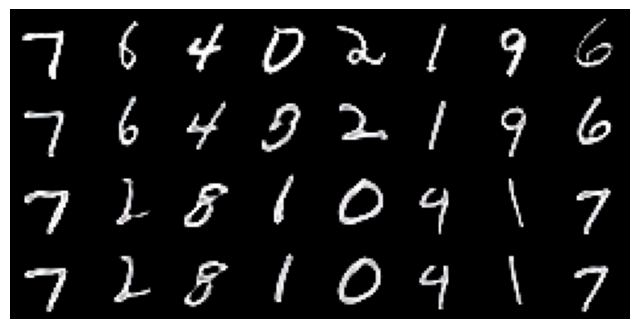

d: 1.2471; g: 0.5012; r1: 0.0046; path: 0.0287; mean path: 0.3938; augment: 0.0000:  87%|████████▋ | 8699/10000 [4:44:44<42:14,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


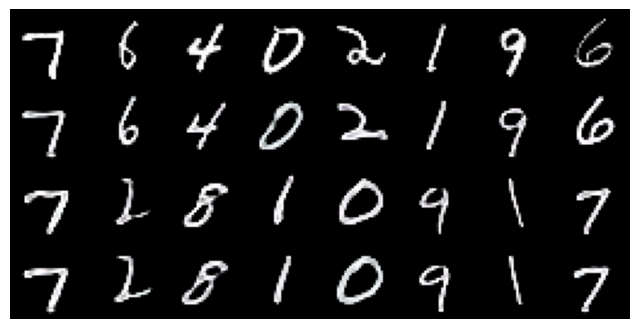

d: 1.2450; g: 0.7177; r1: 0.0192; path: 0.0127; mean path: 0.3930; augment: 0.0000:  88%|████████▊ | 8799/10000 [4:48:00<38:58,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


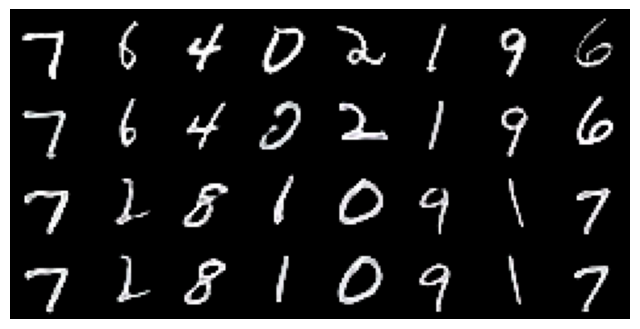

d: 1.3088; g: 0.7492; r1: 0.0185; path: 0.0088; mean path: 0.3960; augment: 0.0000:  89%|████████▉ | 8899/10000 [4:51:16<35:47,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


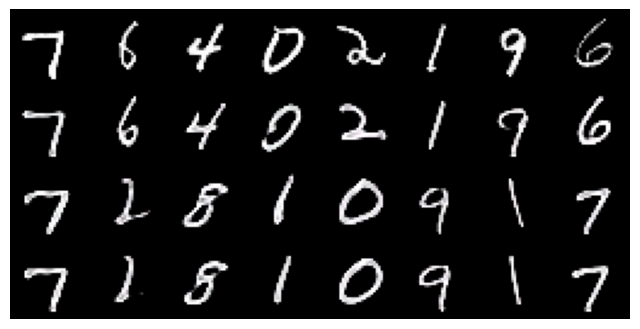

d: 1.2087; g: 0.6948; r1: 0.0036; path: 0.0126; mean path: 0.3960; augment: 0.0000:  90%|████████▉ | 8999/10000 [4:54:32<32:31,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


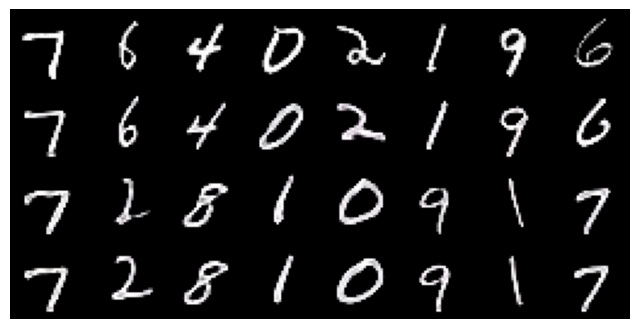

d: 1.3048; g: 0.7103; r1: 0.0039; path: 0.0162; mean path: 0.3992; augment: 0.0000:  91%|█████████ | 9099/10000 [4:57:48<29:14,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


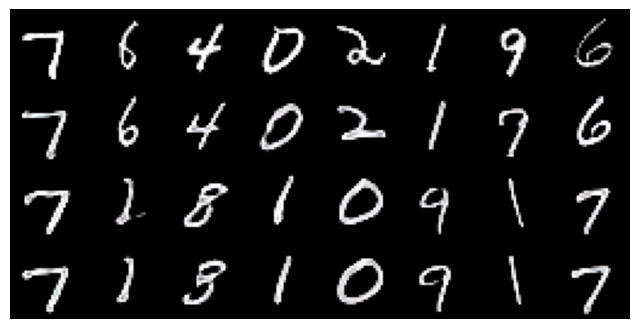

d: 1.2759; g: 0.8112; r1: 0.0046; path: 0.0286; mean path: 0.4006; augment: 0.0000:  92%|█████████▏| 9199/10000 [5:01:03<25:57,  1.94s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


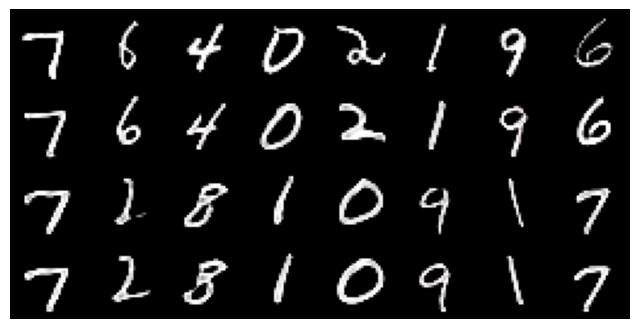

d: 1.3149; g: 0.7172; r1: 0.0077; path: 0.0116; mean path: 0.4006; augment: 0.0000:  93%|█████████▎| 9299/10000 [5:04:19<22:46,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


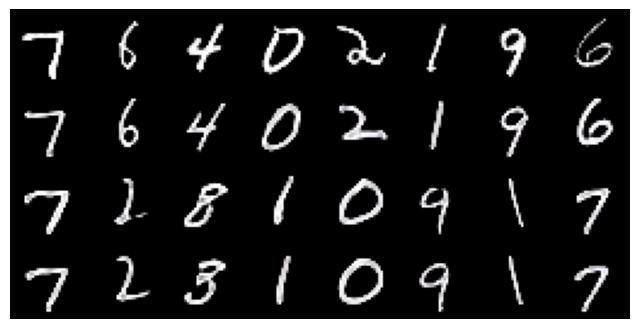

d: 1.3169; g: 0.9977; r1: 0.0030; path: 0.0113; mean path: 0.4018; augment: 0.0000:  94%|█████████▍| 9399/10000 [5:07:35<19:31,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


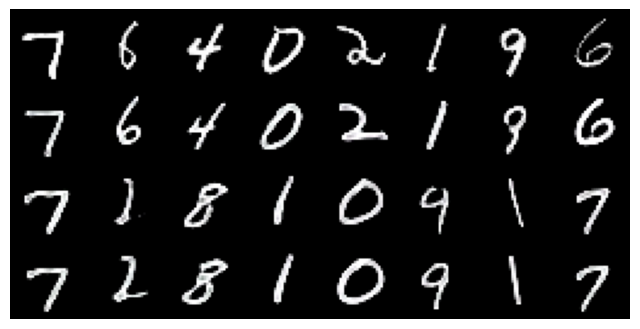

d: 1.2524; g: 0.6655; r1: 0.0068; path: 0.0207; mean path: 0.4044; augment: 0.0000:  95%|█████████▍| 9499/10000 [5:10:51<16:15,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d: 1.2698; g: 0.7489; r1: 0.0189; path: 0.0056; mean path: 0.4058; augment: 0.0000:  96%|█████████▌| 9599/10000 [5:14:06<13:00,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


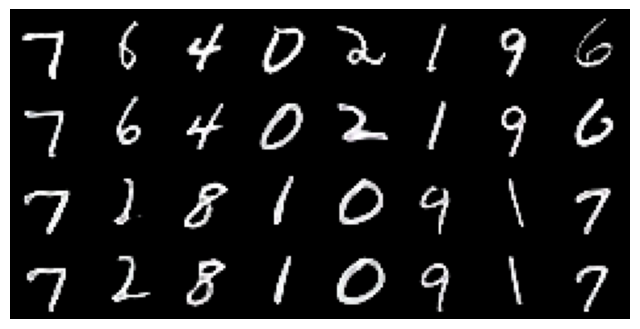

d: 1.2983; g: 0.7895; r1: 0.0052; path: 0.0109; mean path: 0.4070; augment: 0.0000:  97%|█████████▋| 9699/10000 [5:17:23<09:46,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


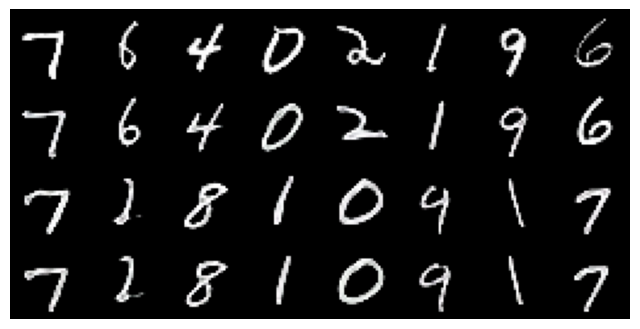

d: 1.2890; g: 0.6112; r1: 0.0064; path: 0.0109; mean path: 0.4059; augment: 0.0000:  98%|█████████▊| 9799/10000 [5:20:38<06:31,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


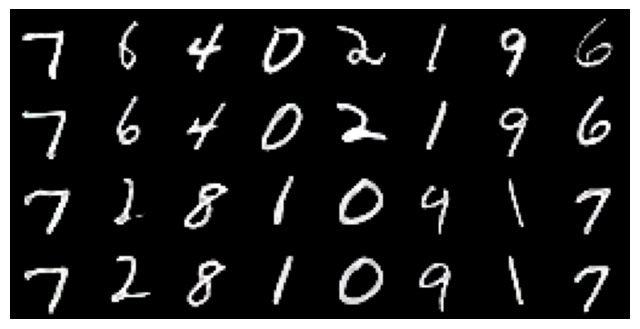

d: 1.2969; g: 0.8951; r1: 0.0101; path: 0.0056; mean path: 0.4070; augment: 0.0000:  99%|█████████▉| 9899/10000 [5:23:54<03:16,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


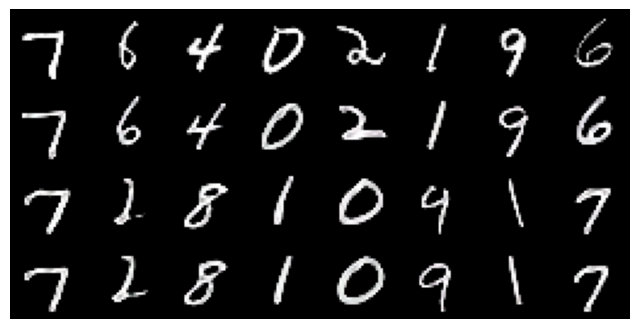

d: 1.3151; g: 0.7498; r1: 0.0064; path: 0.0156; mean path: 0.4058; augment: 0.0000: 100%|█████████▉| 9999/10000 [5:27:10<00:01,  1.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


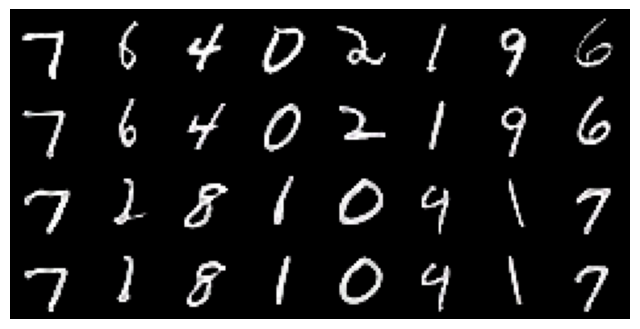

d: 1.3151; g: 0.7498; r1: 0.0064; path: 0.0156; mean path: 0.4058; augment: 0.0000: 100%|██████████| 10000/10000 [5:27:12<00:00,  1.96s/it]


In [ ]:
parser = argparse.ArgumentParser(description="StyleGAN2 trainer")

parser.add_argument("--path", type=str, default='data', help="path to save mnist dataset")
parser.add_argument('--arch', type=str, default='stylegan2', help='model architectures (stylegan2 | swagan)')
parser.add_argument(
    "--iter", type=int, default=800000, help="total training iterations"
)
parser.add_argument(
    "--batch", type=int, default=32, help="batch sizes for each gpus"
)
parser.add_argument(
    "--n_sample",
    type=int,
    default=64,
    help="number of the samples generated during training",
)
parser.add_argument(
    "--r1", type=float, default=10, help="weight of the r1 regularization"
)
parser.add_argument(
    "--path_regularize",
    type=float,
    default=2,
    help="weight of the path length regularization",
)
parser.add_argument(
    "--path_batch_shrink",
    type=int,
    default=2,
    help="batch size reducing factor for the path length regularization (reduce memory consumption)",
)
parser.add_argument(
    "--d_reg_every",
    type=int,
    default=16,
    help="interval of the applying r1 regularization",
)
parser.add_argument(
    "--g_reg_every",
    type=int,
    default=4,
    help="interval of the applying path length regularization",
)
parser.add_argument(
    "--mixing", type=float, default=0.9, help="probability of latent code mixing"
)
parser.add_argument(
    "--ckpt",
    type=str,
    default=None,
    help="path to the checkpoints to resume training",
)
parser.add_argument("--lr", type=float, default=0.002, help="learning rate")
parser.add_argument(
    "--channel_multiplier",
    type=int,
    default=2,
    help="channel multiplier factor for the model. config-f = 2, else = 1",
)
parser.add_argument(
    "--wandb", action="store_true", help="use weights and biases logging"
)
parser.add_argument(
    "--local_rank", type=int, default=0, help="local rank for distributed training"
)
parser.add_argument(
    "--augment", action="store_true", help="apply non leaking augmentation"
)
parser.add_argument(
    "--augment_p",
    type=float,
    default=0,
    help="probability of applying augmentation. 0 = use adaptive augmentation",
)
parser.add_argument(
    "--ada_target",
    type=float,
    default=0.6,
    help="target augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_length",
    type=int,
    default=500 * 1000,
    help="target duraing to reach augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_every",
    type=int,
    default=256,
    help="probability update interval of the adaptive augmentation",
)

parser.add_argument("--gpu", type=str, help="GPU ID")
parser.add_argument("--name", type=str, help="Experiment name")
parser.add_argument("--run_name", type=str, help="Run name")

args = parser.parse_args()

device = f'cuda:{args.gpu}'

n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
args.distributed = n_gpu > 1

if args.distributed:
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    synchronize()

args.latent = 128
args.n_mlp = 8
args.size = 32

args.start_iter = 0

generator = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
mapping = MappingNetwork(args.latent, args.n_mlp,).to(device)
discriminator = DiscriminatorMini(args.latent).to(device)
encoder = Encoder(args.size, args.latent).to(device)
g_ema = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
g_ema.eval()
accumulate(g_ema, generator, 0)

g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

g_optim = optim.Adam(
    generator.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
d_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)
f_optim = optim.Adam(
    mapping.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
e_optim = optim.Adam(
    encoder.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)

if args.ckpt != 'None':
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    generator.load_state_dict(ckpt["g"])
    discriminator.load_state_dict(ckpt["d"])
    mapping.load_state_dict(ckpt["f"])
    encoder.load_state_dict(ckpt["e"])
    g_ema.load_state_dict(ckpt["g_ema"])

    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])
    f_optim.load_state_dict(ckpt["f_optim"])
    e_optim.load_state_dict(ckpt["e_optim"])

if args.distributed:
    generator = nn.parallel.DistributedDataParallel(
        generator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    discriminator = nn.parallel.DistributedDataParallel(
        discriminator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    mapping = nn.parallel.DistributedDataParallel(
        mapping,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    encoder = nn.parallel.DistributedDataParallel(
        encoder,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

transform = transforms.Compose(
    [
        transforms.Grayscale(3),
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,), inplace=True),
    ]
)

dataset = MNIST(args.path, train=True, download=True, transform=transform)

loader = data.DataLoader(
    dataset,
    batch_size=args.batch,
    sampler=data_sampler(dataset, shuffle=True, distributed=args.distributed),
    drop_last=True,
)
loader = sample_data(loader)

debug_images = next(loader)[0][:8].to(device)
debug_noise = generator.make_noise()
debug_z = torch.randn(8, args.latent, device=device)

args.wandb = False
args.wandb


if get_rank() == 0 and wandb is not None and args.wandb:
    wandb.init(project=args.name)
    wandb.run.name = args.run_name
    wandb.run.save()

if not os.path.exists('results'):
    os.mkdir('results')
working_dir = ospj('results', f'{args.name}_{args.run_name}')
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

sample_dir = ospj(working_dir, 'samples')
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)

working_dir = working_dir

images = train(args, loader, generator, discriminator, mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
        sample_dir, working_dir)

## **Umap feature vizualization**

In [ ]:
!pip install umap-learn

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import umap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), inplace=True),
])

dataset = MNIST(root='./data', train=False, download=True, transform=transform)
sampler = SubsetRandomSampler(range(10000))
dataloader_small = DataLoader(dataset, batch_size=1000, sampler=sampler)

encoder.eval()
encoder.to(device)

features_list = []
labels_list = []

for images, labels in dataloader_small:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        features = encoder(images)

    features_list.append(features.cpu().detach().numpy())
    labels_list.append(labels.cpu().detach().numpy())

features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

/content/drive/MyDrive/Deep Learning/gan_utilities/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.3.0+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


## **2D-projection**

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


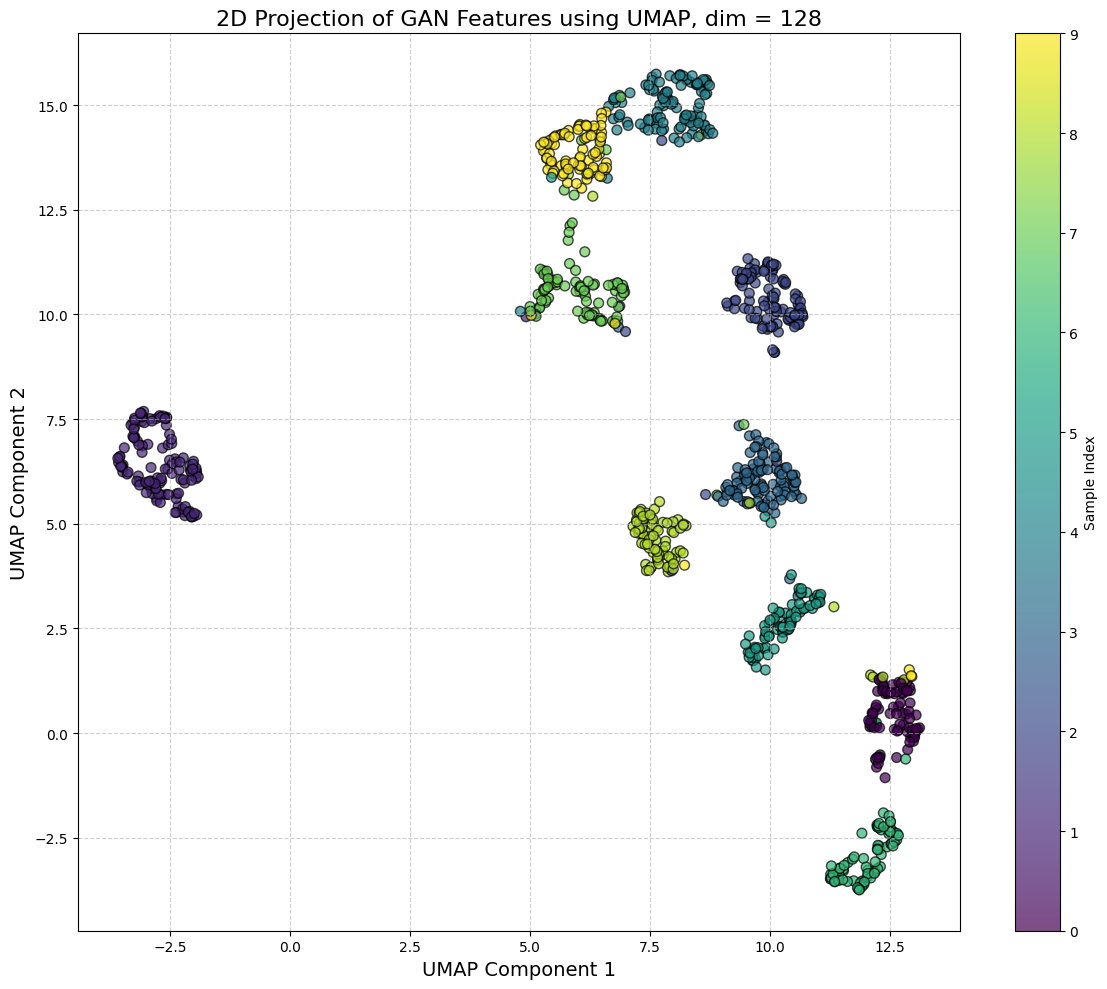

In [ ]:
n_samples = len(features_array)

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_2d = reducer.fit_transform(features_array)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_array, cmap='viridis', alpha=0.7, edgecolor='k', s=50)
plt.colorbar(scatter, label='Sample Index')
plt.title('2D Projection of GAN Features using UMAP, dim = 128', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('umap_projection.png', dpi=300, bbox_inches='tight')
plt.show()

## **Small Net training**

Training a simple two-layer neural network on features obtained from a generative GAN model. Analyzing model accuracy based on varying the number of images per class.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim=128):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        self.input_size = input_size
        self.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

In [ ]:
def extract_features(images, labels, encoder):
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        features = encoder(images)
    return features


def train_model(train_loader, model, criterion, optimizer, encoder, epochs=90, loss_list=[]):
    model.train()
    loss_list = []
    for epoch in tqdm(range(1, epochs+1)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, encoder)
            outputs = model(features)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch}, Loss: {running_loss / len(train_loader):.3f}")
        '''if epoch % 10 == 0:
            accuracy = test_model(model, test_loader, encoder)
            print(f"Accuracy {accuracy}%")'''
    return loss_list


def test_model(model, test_loader, encoder):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            features = torch.tensor(extract_features(images, labels, encoder)).to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
n_classes = 10
batch_size = 4
input_size = 128
hidden_size = 32
n_samples = 16

In [ ]:
train_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

class_indices = [[] for _ in range(n_classes)]
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

selected_indices = []
for indices in class_indices:
    selected_indices.extend(indices[:n_samples])

sampler = SubsetRandomSampler(selected_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
accuracies = {}

In [ ]:
epochs_all = [150, 150, 150, 150, 100, 100, 100, 100, 100]
dataset_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
batch_sizes = [4, 4, 4, 8, 8, 8, 16, 32, 32, 64]

for dataset_size, epochs in zip(dataset_sizes, epochs_all):
    print(f'--------- CALCULATIONS FOR dataset_size={dataset_size} ---------')

    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(indices[:dataset_size])

    sampler = SubsetRandomSampler(selected_indices)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    model = Net(input_size, n_classes, hidden_dim=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = train_model(train_loader, model, criterion, optimizer, encoder, epochs=epochs)
    accuracy = test_model(model, test_loader, encoder)

    print(f'accuracy = {accuracy}%')
    accuracies[dataset_size] = accuracy

--------- CALCULATIONS FOR dataset_size=2 ---------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1, Loss: 2.288
Epoch 2, Loss: 2.238
Epoch 3, Loss: 2.203
Epoch 4, Loss: 2.173
Epoch 5, Loss: 2.139
Epoch 6, Loss: 2.105
Epoch 7, Loss: 2.076
Epoch 8, Loss: 2.044
Epoch 9, Loss: 2.006
Epoch 10, Loss: 1.973
Epoch 11, Loss: 1.936
Epoch 12, Loss: 1.900
Epoch 13, Loss: 1.863
Epoch 14, Loss: 1.824
Epoch 15, Loss: 1.785
Epoch 16, Loss: 1.747
Epoch 17, Loss: 1.707
Epoch 18, Loss: 1.666
Epoch 19, Loss: 1.623
Epoch 20, Loss: 1.584
Epoch 21, Loss: 1.543
Epoch 22, Loss: 1.500
Epoch 23, Loss: 1.459
Epoch 24, Loss: 1.414
Epoch 25, Loss: 1.373
Epoch 26, Loss: 1.334
Epoch 27, Loss: 1.291
Epoch 28, Loss: 1.250
Epoch 29, Loss: 1.211
Epoch 30, Loss: 1.171
Epoch 31, Loss: 1.134
Epoch 32, Loss: 1.097
Epoch 33, Loss: 1.059
Epoch 34, Loss: 1.023
Epoch 35, Loss: 0.988
Epoch 36, Loss: 0.954
Epoch 37, Loss: 0.923
Epoch 38, Loss: 0.890
Epoch 39, Loss: 0.858
Epoch 40, Loss: 0.830
Epoch 41, Loss: 0.805
Epoch 42, Loss: 0.772
Epoch 43, Loss: 0.748
Epoch 44, Loss: 0.723
Epoch 45, Loss: 0.697
Epoch 46, Loss: 0.6

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-30-3515c6ecc82a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(extract_features(images, labels, encoder)).to(device)


accuracy = 81.81%
--------- CALCULATIONS FOR dataset_size=4 ---------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1, Loss: 2.328
Epoch 2, Loss: 2.270
Epoch 3, Loss: 2.226
Epoch 4, Loss: 2.179
Epoch 5, Loss: 2.120
Epoch 6, Loss: 2.059
Epoch 7, Loss: 1.993
Epoch 8, Loss: 1.926
Epoch 9, Loss: 1.846
Epoch 10, Loss: 1.768
Epoch 11, Loss: 1.686
Epoch 12, Loss: 1.600
Epoch 13, Loss: 1.523
Epoch 14, Loss: 1.438
Epoch 15, Loss: 1.356
Epoch 16, Loss: 1.272
Epoch 17, Loss: 1.195
Epoch 18, Loss: 1.124
Epoch 19, Loss: 1.055
Epoch 20, Loss: 0.989
Epoch 21, Loss: 0.932
Epoch 22, Loss: 0.868
Epoch 23, Loss: 0.817
Epoch 24, Loss: 0.767
Epoch 25, Loss: 0.725
Epoch 26, Loss: 0.685
Epoch 27, Loss: 0.640
Epoch 28, Loss: 0.606
Epoch 29, Loss: 0.568
Epoch 30, Loss: 0.542
Epoch 31, Loss: 0.507
Epoch 32, Loss: 0.482
Epoch 33, Loss: 0.460
Epoch 34, Loss: 0.433
Epoch 35, Loss: 0.412
Epoch 36, Loss: 0.393
Epoch 37, Loss: 0.371
Epoch 38, Loss: 0.353
Epoch 39, Loss: 0.336
Epoch 40, Loss: 0.325
Epoch 41, Loss: 0.307
Epoch 42, Loss: 0.292
Epoch 43, Loss: 0.278
Epoch 44, Loss: 0.267
Epoch 45, Loss: 0.255
Epoch 46, Loss: 0.2

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 87.83%
--------- CALCULATIONS FOR dataset_size=8 ---------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1, Loss: 2.292
Epoch 2, Loss: 2.218
Epoch 3, Loss: 2.141
Epoch 4, Loss: 2.056
Epoch 5, Loss: 1.950
Epoch 6, Loss: 1.840
Epoch 7, Loss: 1.736
Epoch 8, Loss: 1.611
Epoch 9, Loss: 1.485
Epoch 10, Loss: 1.366
Epoch 11, Loss: 1.249
Epoch 12, Loss: 1.132
Epoch 13, Loss: 1.028
Epoch 14, Loss: 0.936
Epoch 15, Loss: 0.854
Epoch 16, Loss: 0.777
Epoch 17, Loss: 0.710
Epoch 18, Loss: 0.649
Epoch 19, Loss: 0.601
Epoch 20, Loss: 0.552
Epoch 21, Loss: 0.511
Epoch 22, Loss: 0.472
Epoch 23, Loss: 0.436
Epoch 24, Loss: 0.406
Epoch 25, Loss: 0.381
Epoch 26, Loss: 0.354
Epoch 27, Loss: 0.334
Epoch 28, Loss: 0.312
Epoch 29, Loss: 0.296
Epoch 30, Loss: 0.275
Epoch 31, Loss: 0.261
Epoch 32, Loss: 0.244
Epoch 33, Loss: 0.231
Epoch 34, Loss: 0.220
Epoch 35, Loss: 0.209
Epoch 36, Loss: 0.198
Epoch 37, Loss: 0.186
Epoch 38, Loss: 0.175
Epoch 39, Loss: 0.167
Epoch 40, Loss: 0.157
Epoch 41, Loss: 0.152
Epoch 42, Loss: 0.144
Epoch 43, Loss: 0.138
Epoch 44, Loss: 0.131
Epoch 45, Loss: 0.127
Epoch 46, Loss: 0.1

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 90.68%
--------- CALCULATIONS FOR dataset_size=16 ---------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1, Loss: 2.282
Epoch 2, Loss: 2.111
Epoch 3, Loss: 1.912
Epoch 4, Loss: 1.684
Epoch 5, Loss: 1.434
Epoch 6, Loss: 1.202
Epoch 7, Loss: 0.999
Epoch 8, Loss: 0.830
Epoch 9, Loss: 0.694
Epoch 10, Loss: 0.588
Epoch 11, Loss: 0.504
Epoch 12, Loss: 0.435
Epoch 13, Loss: 0.383
Epoch 14, Loss: 0.334
Epoch 15, Loss: 0.303
Epoch 16, Loss: 0.277
Epoch 17, Loss: 0.247
Epoch 18, Loss: 0.222
Epoch 19, Loss: 0.203
Epoch 20, Loss: 0.187
Epoch 21, Loss: 0.172
Epoch 22, Loss: 0.160
Epoch 23, Loss: 0.147
Epoch 24, Loss: 0.137
Epoch 25, Loss: 0.129
Epoch 26, Loss: 0.121
Epoch 27, Loss: 0.111
Epoch 28, Loss: 0.105
Epoch 29, Loss: 0.097
Epoch 30, Loss: 0.093
Epoch 31, Loss: 0.088
Epoch 32, Loss: 0.082
Epoch 33, Loss: 0.077
Epoch 34, Loss: 0.074
Epoch 35, Loss: 0.071
Epoch 36, Loss: 0.067
Epoch 37, Loss: 0.064
Epoch 38, Loss: 0.060
Epoch 39, Loss: 0.056
Epoch 40, Loss: 0.053
Epoch 41, Loss: 0.051
Epoch 42, Loss: 0.049
Epoch 43, Loss: 0.046
Epoch 44, Loss: 0.044
Epoch 45, Loss: 0.042
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 95.74%
--------- CALCULATIONS FOR dataset_size=32 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 2.191
Epoch 2, Loss: 1.834
Epoch 3, Loss: 1.384
Epoch 4, Loss: 0.992
Epoch 5, Loss: 0.723
Epoch 6, Loss: 0.552
Epoch 7, Loss: 0.445
Epoch 8, Loss: 0.368
Epoch 9, Loss: 0.321
Epoch 10, Loss: 0.277
Epoch 11, Loss: 0.241
Epoch 12, Loss: 0.217
Epoch 13, Loss: 0.198
Epoch 14, Loss: 0.178
Epoch 15, Loss: 0.160
Epoch 16, Loss: 0.147
Epoch 17, Loss: 0.136
Epoch 18, Loss: 0.122
Epoch 19, Loss: 0.114
Epoch 20, Loss: 0.105
Epoch 21, Loss: 0.098
Epoch 22, Loss: 0.092
Epoch 23, Loss: 0.084
Epoch 24, Loss: 0.082
Epoch 25, Loss: 0.074
Epoch 26, Loss: 0.068
Epoch 27, Loss: 0.062
Epoch 28, Loss: 0.061
Epoch 29, Loss: 0.055
Epoch 30, Loss: 0.050
Epoch 31, Loss: 0.049
Epoch 32, Loss: 0.046
Epoch 33, Loss: 0.044
Epoch 34, Loss: 0.041
Epoch 35, Loss: 0.038
Epoch 36, Loss: 0.035
Epoch 37, Loss: 0.033
Epoch 38, Loss: 0.031
Epoch 39, Loss: 0.029
Epoch 40, Loss: 0.028
Epoch 41, Loss: 0.026
Epoch 42, Loss: 0.025
Epoch 43, Loss: 0.025
Epoch 44, Loss: 0.023
Epoch 45, Loss: 0.021
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 96.31%
--------- CALCULATIONS FOR dataset_size=64 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 1.944
Epoch 2, Loss: 1.104
Epoch 3, Loss: 0.627
Epoch 4, Loss: 0.421
Epoch 5, Loss: 0.317
Epoch 6, Loss: 0.260
Epoch 7, Loss: 0.215
Epoch 8, Loss: 0.183
Epoch 9, Loss: 0.163
Epoch 10, Loss: 0.139
Epoch 11, Loss: 0.122
Epoch 12, Loss: 0.113
Epoch 13, Loss: 0.100
Epoch 14, Loss: 0.093
Epoch 15, Loss: 0.085
Epoch 16, Loss: 0.080
Epoch 17, Loss: 0.071
Epoch 18, Loss: 0.064
Epoch 19, Loss: 0.060
Epoch 20, Loss: 0.059
Epoch 21, Loss: 0.051
Epoch 22, Loss: 0.046
Epoch 23, Loss: 0.046
Epoch 24, Loss: 0.044
Epoch 25, Loss: 0.037
Epoch 26, Loss: 0.036
Epoch 27, Loss: 0.035
Epoch 28, Loss: 0.032
Epoch 29, Loss: 0.029
Epoch 30, Loss: 0.028
Epoch 31, Loss: 0.028
Epoch 32, Loss: 0.023
Epoch 33, Loss: 0.023
Epoch 34, Loss: 0.022
Epoch 35, Loss: 0.021
Epoch 36, Loss: 0.021
Epoch 37, Loss: 0.017
Epoch 38, Loss: 0.017
Epoch 39, Loss: 0.015
Epoch 40, Loss: 0.014
Epoch 41, Loss: 0.016
Epoch 42, Loss: 0.013
Epoch 43, Loss: 0.013
Epoch 44, Loss: 0.012
Epoch 45, Loss: 0.011
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 97.25%
--------- CALCULATIONS FOR dataset_size=128 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 1.584
Epoch 2, Loss: 0.596
Epoch 3, Loss: 0.336
Epoch 4, Loss: 0.238
Epoch 5, Loss: 0.192
Epoch 6, Loss: 0.158
Epoch 7, Loss: 0.135
Epoch 8, Loss: 0.121
Epoch 9, Loss: 0.106
Epoch 10, Loss: 0.097
Epoch 11, Loss: 0.092
Epoch 12, Loss: 0.086
Epoch 13, Loss: 0.077
Epoch 14, Loss: 0.074
Epoch 15, Loss: 0.068
Epoch 16, Loss: 0.064
Epoch 17, Loss: 0.060
Epoch 18, Loss: 0.058
Epoch 19, Loss: 0.055
Epoch 20, Loss: 0.051
Epoch 21, Loss: 0.049
Epoch 22, Loss: 0.047
Epoch 23, Loss: 0.041
Epoch 24, Loss: 0.040
Epoch 25, Loss: 0.039
Epoch 26, Loss: 0.038
Epoch 27, Loss: 0.034
Epoch 28, Loss: 0.033
Epoch 29, Loss: 0.031
Epoch 30, Loss: 0.031
Epoch 31, Loss: 0.030
Epoch 32, Loss: 0.027
Epoch 33, Loss: 0.025
Epoch 34, Loss: 0.023
Epoch 35, Loss: 0.024
Epoch 36, Loss: 0.022
Epoch 37, Loss: 0.021
Epoch 38, Loss: 0.022
Epoch 39, Loss: 0.020
Epoch 40, Loss: 0.018
Epoch 41, Loss: 0.019
Epoch 42, Loss: 0.017
Epoch 43, Loss: 0.017
Epoch 44, Loss: 0.015
Epoch 45, Loss: 0.014
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 97.83%
--------- CALCULATIONS FOR dataset_size=256 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 1.155
Epoch 2, Loss: 0.321
Epoch 3, Loss: 0.191
Epoch 4, Loss: 0.149
Epoch 5, Loss: 0.122
Epoch 6, Loss: 0.107
Epoch 7, Loss: 0.095
Epoch 8, Loss: 0.088
Epoch 9, Loss: 0.081
Epoch 10, Loss: 0.076
Epoch 11, Loss: 0.072
Epoch 12, Loss: 0.068
Epoch 13, Loss: 0.065
Epoch 14, Loss: 0.060
Epoch 15, Loss: 0.058
Epoch 16, Loss: 0.056
Epoch 17, Loss: 0.052
Epoch 18, Loss: 0.051
Epoch 19, Loss: 0.048
Epoch 20, Loss: 0.046
Epoch 21, Loss: 0.042
Epoch 22, Loss: 0.041
Epoch 23, Loss: 0.043
Epoch 24, Loss: 0.040
Epoch 25, Loss: 0.038
Epoch 26, Loss: 0.036
Epoch 27, Loss: 0.033
Epoch 28, Loss: 0.033
Epoch 29, Loss: 0.032
Epoch 30, Loss: 0.028
Epoch 31, Loss: 0.032
Epoch 32, Loss: 0.029
Epoch 33, Loss: 0.025
Epoch 34, Loss: 0.030
Epoch 35, Loss: 0.024
Epoch 36, Loss: 0.025
Epoch 37, Loss: 0.022
Epoch 38, Loss: 0.022
Epoch 39, Loss: 0.020
Epoch 40, Loss: 0.023
Epoch 41, Loss: 0.022
Epoch 42, Loss: 0.020
Epoch 43, Loss: 0.018
Epoch 44, Loss: 0.017
Epoch 45, Loss: 0.017
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 98.48%
--------- CALCULATIONS FOR dataset_size=512 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.692
Epoch 2, Loss: 0.166
Epoch 3, Loss: 0.118
Epoch 4, Loss: 0.100
Epoch 5, Loss: 0.086
Epoch 6, Loss: 0.080
Epoch 7, Loss: 0.073
Epoch 8, Loss: 0.066
Epoch 9, Loss: 0.062
Epoch 10, Loss: 0.057
Epoch 11, Loss: 0.055
Epoch 12, Loss: 0.054
Epoch 13, Loss: 0.052
Epoch 14, Loss: 0.049
Epoch 15, Loss: 0.048
Epoch 16, Loss: 0.043
Epoch 17, Loss: 0.043
Epoch 18, Loss: 0.040
Epoch 19, Loss: 0.040
Epoch 20, Loss: 0.037
Epoch 21, Loss: 0.036
Epoch 22, Loss: 0.033
Epoch 23, Loss: 0.034
Epoch 24, Loss: 0.030
Epoch 25, Loss: 0.033
Epoch 26, Loss: 0.030
Epoch 27, Loss: 0.029
Epoch 28, Loss: 0.028
Epoch 29, Loss: 0.026
Epoch 30, Loss: 0.025
Epoch 31, Loss: 0.022
Epoch 32, Loss: 0.024
Epoch 33, Loss: 0.022
Epoch 34, Loss: 0.023
Epoch 35, Loss: 0.021
Epoch 36, Loss: 0.021
Epoch 37, Loss: 0.019
Epoch 38, Loss: 0.021
Epoch 39, Loss: 0.016
Epoch 40, Loss: 0.019
Epoch 41, Loss: 0.015
Epoch 42, Loss: 0.014
Epoch 43, Loss: 0.017
Epoch 44, Loss: 0.014
Epoch 45, Loss: 0.016
Epoch 46, Loss: 0.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 99.4%


In [ ]:
accuracies

{2: 81.81,
 4: 87.83,
 8: 90.68,
 16: 95.74,
 32: 96.31,
 64: 97.25,
 128: 97.83,
 256: 98.48,
 512: 99.4,
 1024: 99.78}